# Exploration Data
This notebook shows data exploration to build a model (or several) in order to classify housing assistance requests thanks to the given datasets.

This is a multi-class classification task

The metric to optimize and the datasets description are explained in DS_technical_test_tutorial.ipynb Jupyter Notebook.

## import

In [352]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)


import numpy as np
import pandas as pd

from sklearn.metrics import log_loss
from sklearn.metrics import classification_report, confusion_matrix

# for geo lat/lon
from geopy.geocoders import Nominatim

## Definition

In [360]:
pwd

'/Users/gregory/Documents/CloudStationSinchon/Applications/python/data-science-test'

In [606]:
PATH_TO_REG = "data/geofrance/regions.csv"
PATH_TO_DEP = "data/geofrance/departments.csv"
PATH_TO_CIT = "data/geofrance/cities.csv"

# EXPORT
PATH_REQ_TRAIN_CLEAN = 'data/requests_train_clean.csv'
PATH_REQ_TEST_CLEAN = 'data/requests_test_clean.csv'

## Useful functions

In [157]:
# Define the test scorer
def competition_scorer(y_true, y_pred):
    return log_loss(y_true, y_pred, sample_weight=10**y_true)


def display_missing(df):
    '''
    Function to display missing values into dataframe.
    Creates a barplots figure and outputs values.

    - input : 
        df : dataframe : data to check
    - output : 
        df_missing : dataframe : table of missing values
    '''
    nb_lignes = df.shape[0]
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    df_missing = nb_missing.to_frame()
    df_missing.rename(index=str, columns={0: "nb_missing"}, inplace=True)
    df_missing["ratio"] = 100*df_missing["nb_missing"] / nb_lignes
    fig = plt.figure(figsize=(7, 7))
    liste_name_bars = df_missing.index.values
    liste_name_bars_num = []
    for name in liste_name_bars:
        liste_name_bars_num.append("{} [{}]".format(
            name, df_missing.loc[name, "nb_missing"]))
    ax = sns.barplot(y=liste_name_bars_num, x='ratio', data=df_missing)
    plt.title('Missing lines Ratio over {} lines'.format(nb_lignes))
    ax.set(xlabel='repartition [%]')
    ax.set_xlim([0, 100])
    return df_missing


def plot_hist_cat(x, data, title):
    '''
    Plot histogram count of categorical data 
    Add proportional information
    '''
    ser_val = data[x].value_counts(dropna=False)
    pc_val = ser_val.values / data[x].shape[0]

    sns.catplot(x=x, kind="count", palette="ch:.25", data=data, 
                height=7, 
                aspect=1.7,
                order=ser_val.index)
    fig = plt.gcf()
    ax = fig.gca()

    for K, y_val in enumerate(ser_val.values):
        ax.text(K, y_val, '{:.2f}'.format(pc_val[K]))
    
    ax.set_title(title)
    
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    
def plot_cont(X,Y,data):
    '''
    Calculate Chi-2 heatmap into contingency table for 
    X event and Y event
    '''
    c = data[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len)
    cont = c.copy()

    tx = data[X].value_counts()
    ty = data[Y].value_counts()

    cont.loc[:,"Total"] = tx
    cont.loc["total",:] = ty
    cont.loc["total","Total"] = len(data)
    cont

    tx = pd.DataFrame(tx)
    ty = pd.DataFrame(ty)
    tx.columns = ["foo"]
    ty.columns = ["foo"]
    n = len(data)
    indep = tx.dot(ty.T) / n

    c = c.fillna(0) # on remplace les valeurs nulles par des 0
    mesure = (c-indep)**2/indep
    xi_n = mesure.sum().sum()
    # plot
    fig = plt.figure(figsize = (5,11.75))
    sns.heatmap(mesure/xi_n, annot=c, fmt=".0f")
    plt.show()
    
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, size=16, fontsize=12, 
                          threshold=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    source : 
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]

    # extract most important confusion if threshold
    if threshold is not None:
      list_idx=[]
      for i in range(0, cm.shape[0]):
        for j in range(0, cm.shape[1]):
          if i != j:
            if cm[i,j] > threshold:
              list_idx.append(i)
              list_idx.append(j)
      list_idx = np.unique(list_idx)
      cm = cm[np.ix_(list_idx, list_idx)]
      classes = classes[list_idx]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
 
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor", fontsize=fontsize)
    # resize y tick labels
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=fontsize,
                    fontweight="black" if i==j else "normal")
    fig.tight_layout()

    fig.set_size_inches([size,size])
    ax.set_ylim([cm.shape[1]-0.5,-0.5]);
    ax.grid(linewidth=0)
    return ax

## Load raw data

In [163]:
requests_train = pd.read_csv(filepath_or_buffer='data/requests_train.csv',
                             sep=',',
                             low_memory=False,
                             error_bad_lines=False)

requests_test = pd.read_csv(filepath_or_buffer='data/requests_test.csv',
                            sep=',',
                            low_memory=False,
                            error_bad_lines=False)


requests_train.head()

,request_id,animal_presence,answer_creation_date,child_situation,child_to_come,district,granted_number_of_nights,group_composition_id,group_composition_label,group_creation_date,...,housing_situation_label,long_term_housing_request,number_of_underage,request_backoffice_creator_id,request_creation_date,requester_type,social_situation_id,town,victim_of_violence,victim_of_violence_type
0,130667d2964de43c511d0ead7ac66b33,f,2019-02-11 22:30:00,-1,NaN,85,1,10,man alone,2018-05-03 12:10:40.416,...,other,NaN,-1,eecd6110b7e9157e6423428b22a28159,2019-02-11 22:30:00,third party,9a84febc47fedaf2c81d7c755e9edc85,NaN,f,NaN
1,b1cd62fcf24eebb0f685d5eaf55317a8,f,2019-02-12 09:00:00,-1,NaN,85,1,10,man alone,2019-03-07 12:11:08.545,...,other,NaN,-1,eecd6110b7e9157e6423428b22a28159,2019-02-12 09:00:00,user,11f64f0547e855c5c59329b9edc63063,NaN,f,NaN
2,12cc0a18890bd4959fe42df3ae58838e,f,2019-02-01 21:00:00,-1,NaN,59,1,80,isolated child/underage,2019-03-13 12:54:15.887,...,street,NaN,-1,686d962128c7622aa79ed91da13f5c77,2019-02-01 21:00:00,user,898ab2883f410f4c6fb042ef16329fbb,NaN,f,NaN
3,ae2d5b4dc181d29e430132f145da1556,f,2019-02-25 15:12:05.037,-1,NaN,50,2,20,woman alone,2018-10-09 14:37:29.773,...,NaN,NaN,-1,ec29519464c381a6630f4e480a0c000e,2019-02-25 15:12:05.037,user,3998c8e890ddc980527dd1af45dfa672,NaN,t,woman
4,d13a17ce36c832514fda2464e11c4a9f,f,2019-02-20 09:59:20.603,-1,NaN,93,2,60,group with child(ren),2018-10-02 10:47:36.931,...,hotel paid by the emergency centre,NaN,-1,c8b5cc926b1d7212224a08baa9619518,2019-02-20 09:59:20.603,user,74a10d96eae43586bc3c46e89719b821,NaN,f,NaN


In [677]:
individuals_train = pd.read_csv(filepath_or_buffer='data/individuals_train.csv',
                                sep=',',
                                low_memory=False,
                                error_bad_lines=False)

individuals_test = pd.read_csv(filepath_or_buffer='data/individuals_test.csv',
                               sep=',',
                               low_memory=False,
                               error_bad_lines=False)

individuals_train.head()

,request_id,individual_id,housing_situation_2_id,housing_situation_2_label,birth_month,birth_year,childcare_center_supervision,disabled_worker_certification,gender,individual_creation_date,individual_role,individual_role_2_id,individual_role_2_label,marital_status_id,marital_status_label,pregnancy
0,130667d2964de43c511d0ead7ac66b33,b24a8cfaaf3663bac45ca3bcd24f0b36,20,on the street,5,1977,NaN,NaN,male,2018-01-29,isolated person,30,isolated adult,10,single person,f
1,b1cd62fcf24eebb0f685d5eaf55317a8,eef783d1bda82661a751c12c34aff8c2,20,on the street,5,1980,NaN,NaN,male,2019-03-07,NaN,30,isolated adult,-1,NaN,f
2,12cc0a18890bd4959fe42df3ae58838e,927b6fa58d6be263c411332835b11fec,20,on the street,1,2003,NaN,NaN,male,2019-03-13,NaN,10,isolated underage/child,-1,NaN,f
3,ae2d5b4dc181d29e430132f145da1556,94181d5cf4a56cc84d12677df84e2e03,20,on the street,7,1986,NaN,NaN,female,2018-10-09,NaN,30,isolated adult,-1,NaN,f
4,d13a17ce36c832514fda2464e11c4a9f,e79d2e3f9ace50049f1796c098008c13,35,hotel paid by the emergency structure,9,1980,NaN,NaN,female,2017-06-22,husband/spouse,1,partner,-1,NaN,f


## Target : classes to predict

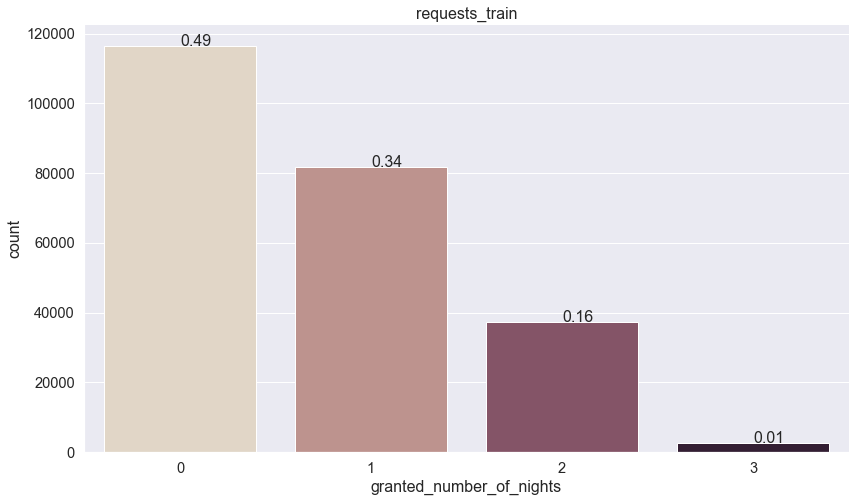

In [149]:
plot_hist_cat(x="granted_number_of_nights", data=requests_train, 
              title="requests_train")

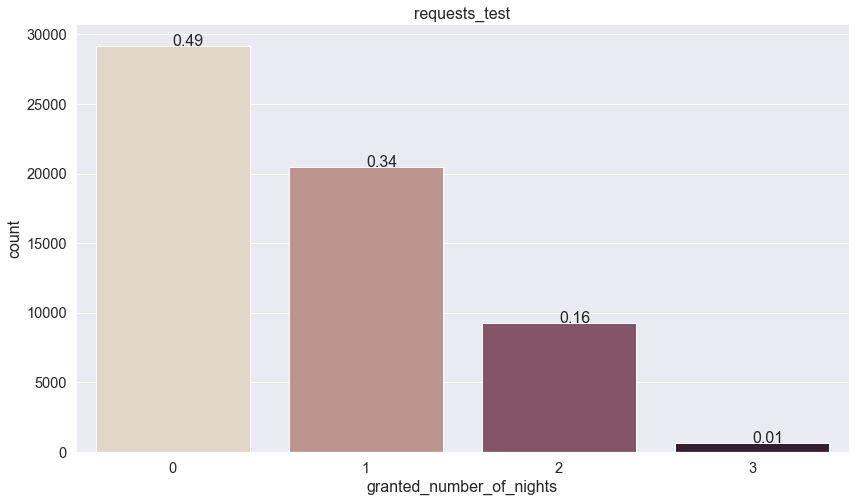

In [150]:
plot_hist_cat(x="granted_number_of_nights", data=requests_test, 
              title="requests_test")

OK => Same proportion in train and test data.

## Missing data

### requests_train

,nb_missing,ratio
request_id,0,0.000000
social_situation_id,0,0.000000
requester_type,0,0.000000
request_creation_date,0,0.000000
request_backoffice_creator_id,0,0.000000
number_of_underage,0,0.000000
housing_situation_id,0,0.000000
group_type,0,0.000000
victim_of_violence,0,0.000000
group_id,0,0.000000


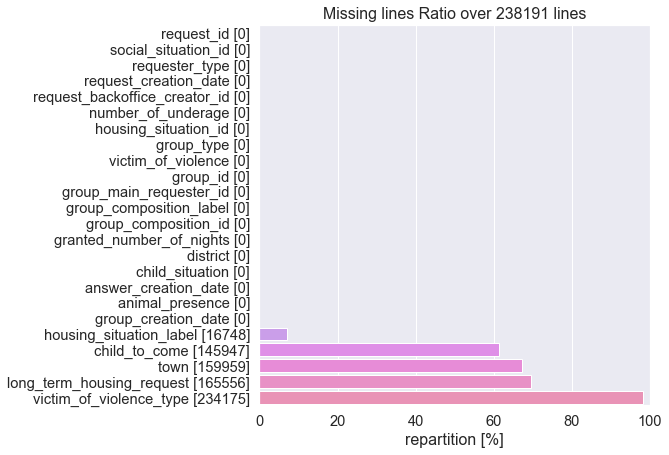

In [22]:
display_missing(requests_train)

In [207]:
requests_train.head().T

,0,1,2,3,4
request_id,130667d2964de43c511d0ead7ac66b33,b1cd62fcf24eebb0f685d5eaf55317a8,12cc0a18890bd4959fe42df3ae58838e,ae2d5b4dc181d29e430132f145da1556,d13a17ce36c832514fda2464e11c4a9f
animal_presence,f,f,f,f,f
answer_creation_date,2019-02-11 22:30:00,2019-02-12 09:00:00,2019-02-01 21:00:00,2019-02-25 15:12:05.037,2019-02-20 09:59:20.603
child_situation,-1,-1,-1,-1,-1
child_to_come,unknown,unknown,unknown,unknown,unknown
district,85,85,59,50,93
granted_number_of_nights,1,1,1,2,2
group_composition_id,10,10,80,20,60
group_composition_label,man alone,man alone,isolated child/underage,woman alone,group with child(ren)
group_creation_date,2018-05-03 12:10:40.416,2019-03-07 12:11:08.545,2019-03-13 12:54:15.887,2018-10-09 14:37:29.773,2018-10-02 10:47:36.931


In [56]:
requests_train["housing_situation_label"].value_counts(dropna=False)

street                                         101885
emergency structure                             68512
hotel paid by the emergency centre              17052
NaN                                             16748
other                                            9340
accomodation by a third party                    9171
shelters                                         4238
mobile or makeshift shelter                      2832
public hospital                                  2170
personal or marital home                         1722
hotel paid by the household                       810
refused to answer                                 807
hotel paid by the regional administration         660
inclusion structure                               468
parental home                                     396
psychiatric hospital                              308
stabilisation structure                           298
hotel paid by an association                      269
religious place (church, mos

### requests_test

,nb_missing,ratio
request_id,0,0.000000
social_situation_id,0,0.000000
requester_type,0,0.000000
request_creation_date,0,0.000000
request_backoffice_creator_id,0,0.000000
number_of_underage,0,0.000000
housing_situation_id,0,0.000000
group_id,0,0.000000
group_main_requester_id,0,0.000000
group_composition_id,0,0.000000


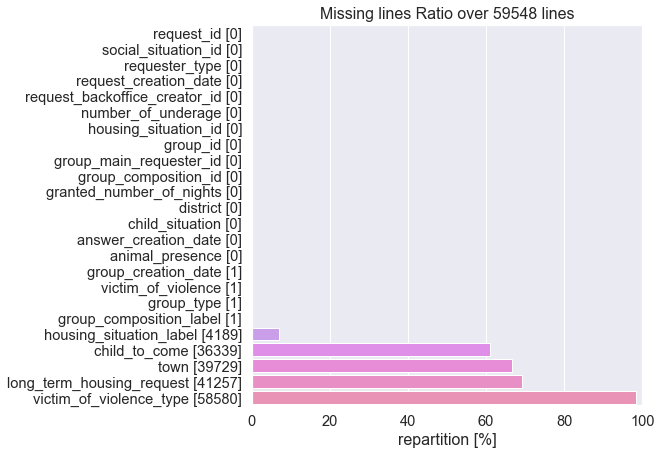

In [23]:
display_missing(requests_test)

### individuals_train

,nb_missing,ratio
request_id,0,0.000000
individual_id,0,0.000000
housing_situation_2_id,0,0.000000
housing_situation_2_label,0,0.000000
birth_month,0,0.000000
birth_year,0,0.000000
individual_role_2_id,0,0.000000
marital_status_id,0,0.000000
gender,1,0.000260
pregnancy,14,0.003645


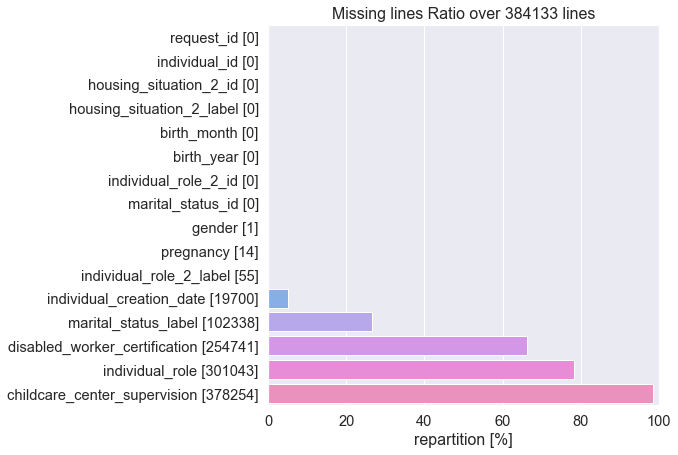

In [24]:
display_missing(individuals_train)

In [183]:
individuals_train.shape[0]

384133

In [182]:
individuals_train["request_id"].nunique()

238191

In [200]:
requests_train["request_id"].nunique()

238191

In [184]:
individuals_train["individual_id"].nunique()

83513

Several individuals for one request

And one individual can have multiple status (during time ?)

### individuals_test

,nb_missing,ratio
request_id,0,0.000000
individual_id,0,0.000000
housing_situation_2_id,0,0.000000
housing_situation_2_label,0,0.000000
birth_month,0,0.000000
birth_year,0,0.000000
individual_role_2_id,0,0.000000
marital_status_id,0,0.000000
gender,1,0.001046
pregnancy,4,0.004182


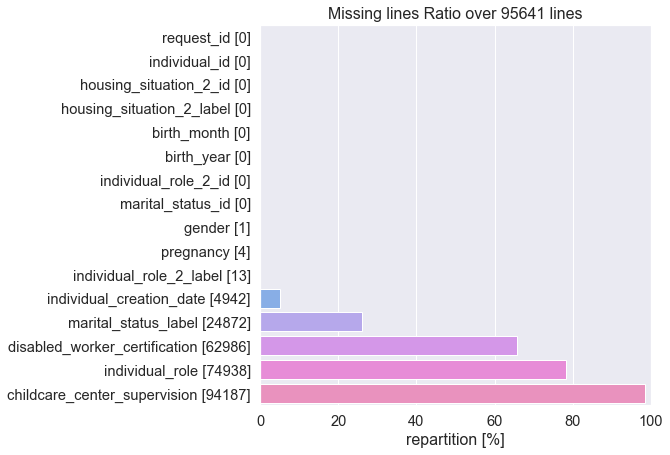

In [25]:
display_missing(individuals_test)

In [201]:
individuals_test.shape[0]

95641

In [202]:
individuals_test["request_id"].nunique()

59548

In [203]:
requests_test["request_id"].nunique()

59548

All request_id from requests_test are into individuals_test

In [204]:
individuals_test["individual_id"].nunique()

42915

## Correlations

### Correct housing_situation_label
Only label 170 is unkonwn => add a housing_situation_label = "unknown"


housing_situation_label have some impact on number of nights
So we must keep it and check Nan Value???

In [73]:
requests_train["housing_situation_id"].value_counts(dropna=False)

200    101885
10      68512
50      17052
170     16748
160      9340
120      9171
100      4238
110      2832
130      2170
80       1722
40        810
180       807
190       660
30        468
70        396
140       308
20        298
220       269
210       235
150       147
60         85
90         38
Name: housing_situation_id, dtype: int64

In [74]:
requests_train["housing_situation_id"].nunique()

22

In [75]:
requests_train["housing_situation_label"].nunique() 

21

In [77]:
requests_train[requests_train["housing_situation_label"].\
               isna()]["housing_situation_id"].value_counts(dropna=False)

170    16748
Name: housing_situation_id, dtype: int64

In [154]:
requests_test[requests_test["housing_situation_label"].\
               isna()]["housing_situation_id"].value_counts(dropna=False)

170    4189
Name: housing_situation_id, dtype: int64

In [160]:
requests_train[requests_train["housing_situation_label"].isna()]

,request_id,animal_presence,answer_creation_date,child_situation,child_to_come,district,granted_number_of_nights,group_composition_id,group_composition_label,group_creation_date,...,housing_situation_label,long_term_housing_request,number_of_underage,request_backoffice_creator_id,request_creation_date,requester_type,social_situation_id,town,victim_of_violence,victim_of_violence_type
3,ae2d5b4dc181d29e430132f145da1556,f,2019-02-25 15:12:05.037,-1,NaN,50,2,20,woman alone,2018-10-09 14:37:29.773,...,NaN,NaN,-1,ec29519464c381a6630f4e480a0c000e,2019-02-25 15:12:05.037,user,3998c8e890ddc980527dd1af45dfa672,NaN,t,woman
18,e7f5a33909899231d96518842d115f23,f,2019-02-28 09:35:23.766,-1,NaN,64,0,10,man alone,2018-11-13 12:02:02.667,...,NaN,NaN,-1,2b34d48f97e14e49e1b153eb66644809,2019-02-28 09:35:23.766,user,495f0e10efffa704d9a6df257801f146,NaN,f,NaN
30,9223b74676220e533c31db6af6a94103,f,2019-02-28 18:14:35.252,-1,NaN,51,1,10,man alone,2019-02-18 20:16:56.112,...,NaN,NaN,-1,63e83fbbebdabecde1fe46696f811ed0,2019-02-28 18:14:35.252,user,94a8e9f8ededc41000b196c80df6d898,NaN,f,NaN
80,2d824ff45b8cdb87f2bc8e52ad97965f,f,2019-02-11 20:01:57.84,-1,NaN,51,0,10,man alone,2018-09-11 13:10:40.766,...,NaN,NaN,-1,63e83fbbebdabecde1fe46696f811ed0,2019-02-11 20:01:57.84,user,3e9d94a773736db14f13284fcfdcfa05,NaN,f,NaN
81,ad259fa68cc877c0d0813cbced0cefc9,f,2019-02-11 16:00:00,-1,NaN,26,1,10,man alone,2018-02-13 09:05:59.542,...,NaN,NaN,-1,9af5353cfd70982178a626350a72c4ac,2019-02-11 16:00:00,user,46375da7795ff8e5ab47ecb634ba1d7d,NaN,f,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238072,07d231ff2a7806ad6d10482d8afe3e40,f,2019-01-15 10:25:22.534,-1,f,50,0,10,man alone,2017-03-16 00:00:00.000,...,NaN,f,0,dc07b73c407e8db6e9d67a5e280dc5aa,2019-01-15 10:25:22.534,user,46847766c45846242b299e862ecf7f05,Caen,t,man
238087,0e2dbe3d86083c0b488809ed6fc505fc,f,2019-01-21 13:06:00,-1,NaN,17,0,10,man alone,2018-08-22 09:41:26.198,...,NaN,NaN,-1,4d07bdbcbf6bdae430698479ea046910,2019-01-21 13:06:00,user,5d1f069f1d71e4cca8695b36cb0d723b,NaN,f,NaN
238101,8a4075d15ad94d1a476c190ed129b421,f,2019-01-25 22:37:11.675,-1,f,63,0,20,woman alone,2018-07-01 20:40:38.068,...,NaN,NaN,-1,1af382081d6b4b9fc610c4df9c51a95b,2019-01-25 22:37:11.675,user,dbd03f487a6bc640e7d29bc0f22ee1b1,NaN,f,NaN
238116,15749cfd95735a53128c9d03f3b11be5,f,2019-01-03 15:34:06.869,-1,NaN,17,2,20,woman alone,2018-12-07 09:28:41.166,...,NaN,NaN,-1,9ef01bc20261d230caf2778b4a02ad4c,2019-01-03 15:34:06.869,user,7374a47d91d981183b62a82225687b14,NaN,f,NaN


In [165]:
requests_train.loc[requests_train["housing_situation_label"].\
               isna(), "housing_situation_label"] = "unknown"

In [166]:
requests_train[requests_train["housing_situation_label"].isna()]

,request_id,animal_presence,answer_creation_date,child_situation,child_to_come,district,granted_number_of_nights,group_composition_id,group_composition_label,group_creation_date,...,housing_situation_label,long_term_housing_request,number_of_underage,request_backoffice_creator_id,request_creation_date,requester_type,social_situation_id,town,victim_of_violence,victim_of_violence_type


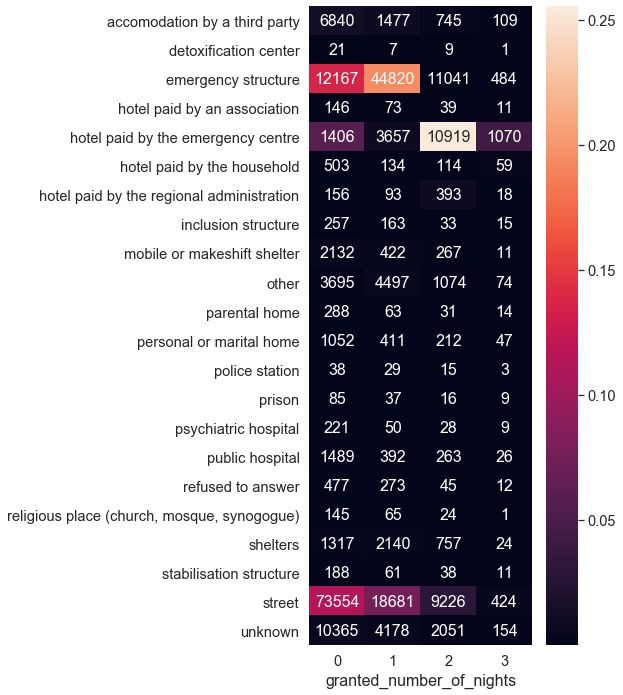

In [253]:
plot_cont(X="housing_situation_label",
    Y="granted_number_of_nights",
    data=requests_train)

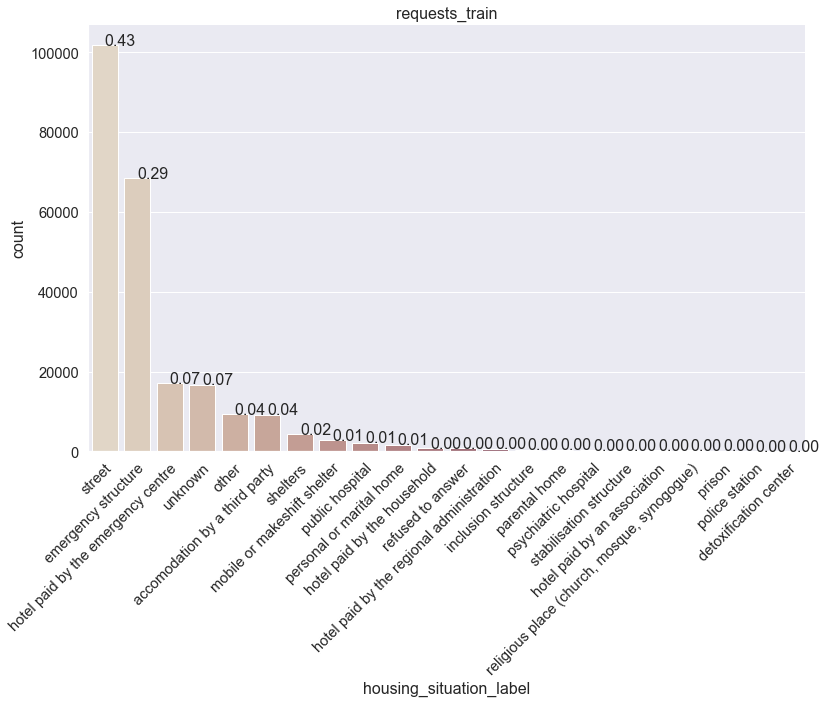

In [167]:
plot_hist_cat(x="housing_situation_label", data=requests_train, 
              title="requests_train")

In [168]:
requests_test.loc[requests_test["housing_situation_label"].\
               isna(), "housing_situation_label"] = "unknown"

In [169]:
requests_test[requests_test["housing_situation_label"].isna()]

,request_id,animal_presence,answer_creation_date,child_situation,child_to_come,district,granted_number_of_nights,group_composition_id,group_composition_label,group_creation_date,...,housing_situation_label,long_term_housing_request,number_of_underage,request_backoffice_creator_id,request_creation_date,requester_type,social_situation_id,town,victim_of_violence,victim_of_violence_type


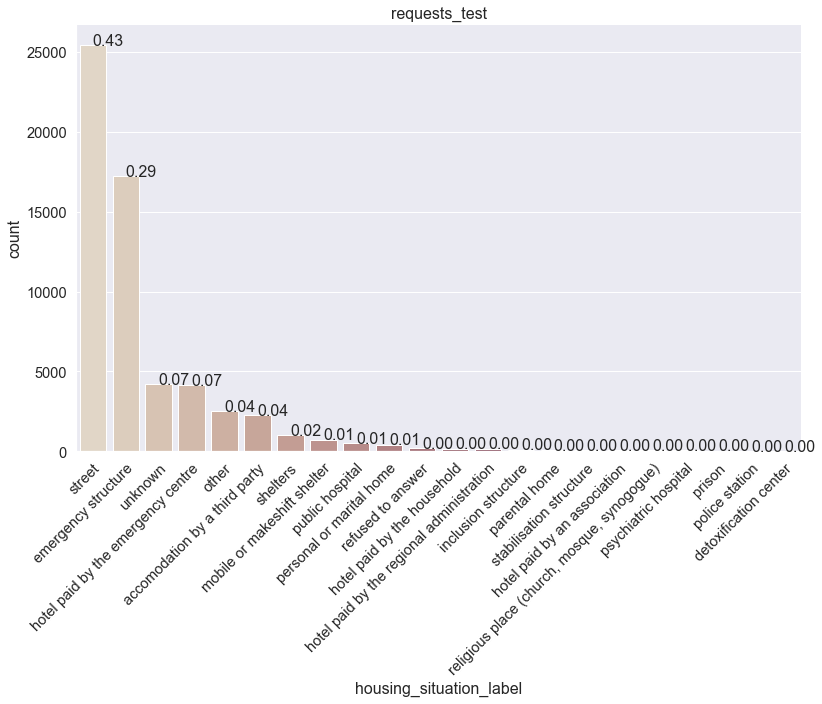

In [170]:
plot_hist_cat(x="housing_situation_label", data=requests_test, 
              title="requests_test")

In [240]:
requests_train["housing_situation_label"].nunique()

22

In [241]:
requests_test["housing_situation_label"].nunique()

22

In [242]:
requests_train["housing_situation_label"].unique()

array(['other', 'street', 'unknown', 'hotel paid by the emergency centre',
       'emergency structure', 'accomodation by a third party',
       'personal or marital home', 'parental home',
       'mobile or makeshift shelter', 'hotel paid by the household',
       'hotel paid by an association', 'stabilisation structure',
       'psychiatric hospital', 'shelters',
       'hotel paid by the regional administration', 'public hospital',
       'refused to answer', 'prison', 'inclusion structure',
       'religious place (church, mosque, synogogue)', 'police station',
       'detoxification center'], dtype=object)

In [243]:
requests_test["housing_situation_label"].unique()

array(['street', 'public hospital', 'emergency structure', 'unknown',
       'hotel paid by the household', 'accomodation by a third party',
       'hotel paid by the emergency centre', 'other', 'shelters',
       'personal or marital home', 'stabilisation structure',
       'hotel paid by the regional administration',
       'hotel paid by an association', 'inclusion structure',
       'mobile or makeshift shelter', 'prison', 'detoxification center',
       'refused to answer', 'parental home',
       'religious place (church, mosque, synogogue)', 'police station',
       'psychiatric hospital'], dtype=object)

Check if same ensemble of labels in Test and Train : 

In [244]:
print('Colonnes dans Train et pas dans Test : ')
set(requests_train["housing_situation_label"].unique().tolist()) \
    .difference(requests_test["housing_situation_label"].unique().tolist())

Colonnes dans Train et pas dans Test : 


set()

In [245]:
print('Colonnes dans Test et pas dans Train : ')
set(requests_test["housing_situation_label"].unique().tolist()) \
    .difference(requests_train["housing_situation_label"].unique().tolist())

Colonnes dans Test et pas dans Train : 


set()

=> OK same

Check if one individual of a group can represent the housing situation of group : 

For that, check if there is only 1 housing_situation_2_id for all individuals linked to 1 request into individuals_train & individuals_test.

In [252]:
individuals_train["housing_situation_2_id"].nunique()

28

In [178]:
individuals_train["housing_situation_2_id"].value_counts(dropna=False)

20    289870
35     39716
32     14872
47     14479
29      6694
44      6449
22      2599
36      2413
30      1602
34      1332
26       953
37       494
23       437
38       365
28       280
42       271
27       243
21       236
31       223
46       173
45       146
40        89
33        81
25        46
43        32
39        21
24        15
41         2
Name: housing_situation_2_id, dtype: int64

In [180]:
individuals_train["housing_situation_2_label"].value_counts(dropna=False)

on the street                                      289870
hotel paid by the emergency structure               39716
emergency accomodation                              14872
day center, social services, associations           14479
accomodated by friends or other                      6694
other                                                6449
reception center for asylum seeker                   2599
public instition (hospital, retirement home)         2413
accomodated by family                                1602
hotel not paid by an emergency structure             1332
winter plan center                                    953
private housing rental                                494
emergency accomodation centre for asylum seeker       437
public housing rental                                 365
residential roaming                                   280
child care                                            271
medical centre                                        243
emergency cent

In [208]:
individuals_train["request_id"].nunique()

238191

In [209]:
individuals_train.shape[0]

384133

In [ ]:
def fun_check_unique(id_curr):
    list_id = individuals_train[individuals_train["request_id"] == \
                         id_curr]["housing_situation_2_id"].values
    return np.all(list_id == list_id[0])
#requests_train["flag_unique_hs"] = \
#    requests_train["request_id"].apply(fun_check_unique)

In [222]:
def fun_nunique(serie_in):
    return serie_in.nunique()

pt_req_hs_nb = pd.pivot_table(individuals_train, 
                              values='housing_situation_2_id', 
               index=['request_id'], aggfunc=fun_nunique)
pt_req_hs_nb

,housing_situation_2_id
request_id,
0000602749161524aedd04269957e5fc,1
0000c66f6bb24e930cba6a3872d3ab02,1
0000dbd253c096eab97cab0545915ab2,1
0001826bdd626262ec2bda3a1b908aac,1
0001925b4cd4d65110638ee3d5f2f454,1
...,...
fffd7c7c22a9147bc4af4b869eb97f19,1
fffeeac2155c826f0ccc2f912c1049f9,1
fffeff160a0bf8c160c9e63436273cec,1


In [223]:
pt_req_hs_nb["housing_situation_2_id"].value_counts()

1    238191
Name: housing_situation_2_id, dtype: int64

In [224]:
pt_req_hs_nb_test = pd.pivot_table(individuals_test, 
                              values='housing_situation_2_id', 
                              index=['request_id'], 
                              aggfunc=fun_nunique)
pt_req_hs_nb_test

,housing_situation_2_id
request_id,
00025115a1823cf8dc4e405fac55aa08,1
000329aa7e358635d26ff2d82a3f51d9,1
00035ca76ed77fd146fbd433fdccd8a5,1
0004db4b2bf9997bbd68d59c5c4d65a5,1
00072464a3949529d9093a7622806527,1
...,...
fffd6850c8daf68dcdf737647952f40d,1
fffe858cbae1fcf6093a9676d81119d9,1
fffec8a1dff845182d68e56ed8329a37,1


In [225]:
pt_req_hs_nb_test["housing_situation_2_id"].value_counts()

1    59548
Name: housing_situation_2_id, dtype: int64

=> Every request in individual tables have only one housing_situation

We can use it directly to add data into request table (for missing values)

We can also add a data column (feature) with these information for future use

Create table to link request id with one unique housing_situation_2_id : 

In [229]:
def fun_first(serie_in):
    return serie_in.values[0]

pt_req_hs_train = pd.pivot_table(individuals_train, 
                                 values='housing_situation_2_label', 
                                 index=['request_id'], aggfunc=fun_first)

pt_req_hs_test = pd.pivot_table(individuals_test, 
                                 values='housing_situation_2_label', 
                                 index=['request_id'], aggfunc=fun_first)
pt_req_hs_train

,housing_situation_2_label
request_id,
0000602749161524aedd04269957e5fc,on the street
0000c66f6bb24e930cba6a3872d3ab02,on the street
0000dbd253c096eab97cab0545915ab2,on the street
0001826bdd626262ec2bda3a1b908aac,on the street
0001925b4cd4d65110638ee3d5f2f454,on the street
...,...
fffd7c7c22a9147bc4af4b869eb97f19,on the street
fffeeac2155c826f0ccc2f912c1049f9,on the street
fffeff160a0bf8c160c9e63436273cec,emergency accomodation


Join this data  to request tables : 

In [236]:
df_test = requests_train.copy()
df_test = df_test.join(pt_req_hs_train, on="request_id")
df_test.head().T

,0,1,2,3,4
request_id,130667d2964de43c511d0ead7ac66b33,b1cd62fcf24eebb0f685d5eaf55317a8,12cc0a18890bd4959fe42df3ae58838e,ae2d5b4dc181d29e430132f145da1556,d13a17ce36c832514fda2464e11c4a9f
animal_presence,f,f,f,f,f
answer_creation_date,2019-02-11 22:30:00,2019-02-12 09:00:00,2019-02-01 21:00:00,2019-02-25 15:12:05.037,2019-02-20 09:59:20.603
child_situation,-1,-1,-1,-1,-1
child_to_come,unknown,unknown,unknown,unknown,unknown
district,85,85,59,50,93
granted_number_of_nights,1,1,1,2,2
group_composition_id,10,10,80,20,60
group_composition_label,man alone,man alone,isolated child/underage,woman alone,group with child(ren)
group_creation_date,2018-05-03 12:10:40.416,2019-03-07 12:11:08.545,2019-03-13 12:54:15.887,2018-10-09 14:37:29.773,2018-10-02 10:47:36.931


In [237]:
requests_train = df_test.copy()

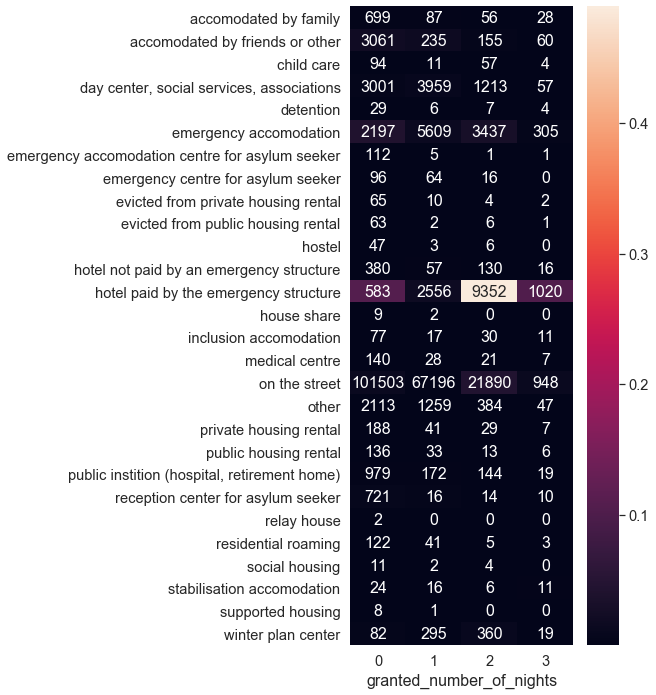

In [272]:
plot_cont(X="housing_situation_2_label",
Y="granted_number_of_nights",
data=requests_train)

In [238]:
df_test = requests_test.copy()
df_test = df_test.join(pt_req_hs_test, on="request_id")
df_test.head().T

,0,1,2,3,4
request_id,6a94e460b649033f78a6b136815364af,732820e77e68d6b8ac6da919b7c08da1,415696df2fef0b6a4d7e07b36d12dc7f,545fc3ead390446a3b08b71a44188d70,2fd26167f6d41e6422962887f42eef90
animal_presence,f,f,f,f,f
answer_creation_date,2019-02-27 08:21:23.301,2019-02-27 15:06:56.757,2019-02-27 09:53:34.537,2019-02-27 20:19:11.887,2019-02-27 11:31:58.067
child_situation,-1,-1,-1,-1,-1
child_to_come,NaN,NaN,NaN,NaN,NaN
district,60,35,100,95,13
granted_number_of_nights,0,0,0,0,0
group_composition_id,40,10,20,10,10
group_composition_label,single mother with child(ren),man alone,woman alone,man alone,man alone
group_creation_date,2019-01-23 11:26:20.206,2019-02-25 12:20:46.138,2019-02-27 09:54:57.263,2019-01-30 17:41:20.532,2018-12-11 16:54:03.526


In [239]:
requests_test = df_test.copy()

To not add too mush dimensions to features list for model, 

we choose to correct data from requests tables by information from individuals tables

unknown and other requests housing label will be translate in requests tables existing label.

List of corresponding label if label = other :

In [258]:
requests_train[requests_train["housing_situation_label"] == 'other'] \
    ["housing_situation_2_label"].unique().tolist()

['on the street',
 'other',
 'day center, social services, associations',
 'public instition (hospital, retirement home)',
 'public housing rental',
 'reception center for asylum seeker',
 'residential roaming',
 'emergency accomodation',
 'hotel not paid by an emergency structure',
 'evicted from private housing rental',
 'medical centre',
 'accomodated by friends or other',
 'child care',
 'emergency accomodation centre for asylum seeker',
 'detention',
 'winter plan center',
 'hotel paid by the emergency structure',
 'accomodated by family',
 'inclusion accomodation',
 'evicted from public housing rental',
 'stabilisation accomodation',
 'social housing',
 'hostel',
 'emergency centre for asylum seeker',
 'house share',
 'private housing rental']

In [259]:
requests_train["housing_situation_label"].unique().tolist()

['other',
 'street',
 'unknown',
 'hotel paid by the emergency centre',
 'emergency structure',
 'accomodation by a third party',
 'personal or marital home',
 'parental home',
 'mobile or makeshift shelter',
 'hotel paid by the household',
 'hotel paid by an association',
 'stabilisation structure',
 'psychiatric hospital',
 'shelters',
 'hotel paid by the regional administration',
 'public hospital',
 'refused to answer',
 'prison',
 'inclusion structure',
 'religious place (church, mosque, synogogue)',
 'police station',
 'detoxification center']

In [282]:
val_count = requests_train[requests_train["housing_situation_2_label"] == \
                'day center, social services, associations'] \
    ["housing_situation_label"].value_counts()
val_count

emergency structure                            3680
street                                         1431
unknown                                         920
shelters                                        761
accomodation by a third party                   388
other                                           304
hotel paid by the emergency centre              152
personal or marital home                        146
mobile or makeshift shelter                     119
public hospital                                 103
refused to answer                                50
hotel paid by the household                      34
inclusion structure                              28
parental home                                    23
hotel paid by an association                     22
stabilisation structure                          18
religious place (church, mosque, synogogue)      13
police station                                   11
hotel paid by the regional administration        10
prison      

In [286]:
val_count.index[0]

'emergency structure'

In [278]:
requests_train[requests_train["housing_situation_label"] == \
               "detoxification center"].T

,26632,29504,34466,35699,48969,67763,68094,72075,82156,88908,...,178943,185169,193902,196819,202033,215692,218317,229443,230267,235269
request_id,cd016d5d25ed25f1f96be819cf71bfc1,016d1b32e413536d7991d6ebcad6b53d,7ee1595272126e3666f7d2ae652720c5,0c737f50d3f0f52c762f4e3c157be146,9f1192e71e5ac0b90c5599c358bf55f1,31be2e5e3b1d2b09af96c2e99121b02a,e828c32baeace3bdccbedeeb6db3ccdc,8dbd18cce50b6ac2a348d386cd4b028f,20794ae1e7d86698a233d6336052e95f,1ed06956c76628bf6615feda6ee7b2ed,...,478a109a481dcfdf5e455f1c4cf4251a,d9b2690358cc9b9b4f871737b7998b06,491bad91b2edbb65c071466d6f284311,f1771999d16d92d56026be357c0f79b1,0798caaa3a6cf61994996a148f6880ee,2ef855a59810775491454205be4c0876,6a7a5e8ec4e77b104d75c5e31400b7ac,a0fbb9e1898a7f045aee7d6ef58385ab,a5c8419c1186b68fe039544e4a0fb9fb,b752eaff2246ad01791b744aea6b4467
animal_presence,f,f,f,f,f,f,f,f,f,f,...,f,f,f,f,f,f,f,f,f,f
answer_creation_date,2019-02-18 15:19:52.472,2019-02-07 21:16:09.276,2019-02-11 17:00:00,2019-02-07 10:56:43.444,2019-02-27 14:30:26.919,2019-02-14 15:05:00,2019-02-04 10:52:31.171,2019-02-06 13:03:41.969,2019-03-27 16:03:15.248,2019-03-11 12:47:16.79,...,2019-01-07 14:00:00,2019-01-13 07:52:43.349,2019-01-18 13:03:11.953,2019-01-29 09:44:12.484,2019-01-20 13:19:48.523,2019-01-14 09:32:29.606,2019-01-08 21:58:30.988,2019-01-11 14:00:00,2019-01-18 09:50:00,2019-01-03 12:15:29.179
child_situation,-1,-1,70,-1,-1,-1,10,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
child_to_come,unknown,f,f,f,unknown,unknown,unknown,unknown,f,f,...,unknown,unknown,f,unknown,f,unknown,f,unknown,f,f
district,90,95,63,43,314550,40,95,84,84,79,...,40,60,52,60,92,60,78,314550,25,61
granted_number_of_nights,0,0,2,0,0,1,0,0,0,2,...,2,0,0,1,0,0,0,2,2,0
group_composition_id,10,10,20,10,10,10,100,20,10,10,...,10,10,10,10,50,10,20,10,10,10
group_composition_label,man alone,man alone,woman alone,man alone,man alone,man alone,couple with child(ren),woman alone,man alone,man alone,...,man alone,man alone,man alone,man alone,single father with child(ren),man alone,woman alone,man alone,man alone,man alone
group_creation_date,2018-03-23 17:24:13.498,2019-02-07 21:23:29.737,2018-11-04 15:13:36.652,2019-02-07 10:57:31.934,2019-02-27 14:23:48.679,2019-01-07 20:17:57.029,2019-02-04 10:56:12.029,2019-02-06 13:04:54.433,2017-12-05 13:17:47.618,2019-01-22 11:12:52.883,...,2019-01-07 20:17:57.029,2018-12-10 16:37:52.867,2018-08-01 16:37:14.931,2018-07-11 18:36:59.120,2018-11-05 19:51:29.775,2018-11-19 11:45:53.697,2018-12-31 17:57:31.711,2019-01-22 09:09:22.595,2017-09-03 00:00:00.000,2014-08-11 00:00:00.000


In [279]:
individuals_train[individuals_train["request_id"] \
                  == "cd016d5d25ed25f1f96be819cf71bfc1"].T

,42592
request_id,cd016d5d25ed25f1f96be819cf71bfc1
individual_id,689374bd45d7911e77796e86eeb8938a
housing_situation_2_id,20
housing_situation_2_label,on the street
birth_month,6
birth_year,1974
childcare_center_supervision,NaN
disabled_worker_certification,NaN
gender,male
individual_creation_date,2018-03-23


Create a dictionnary with most represented  housing_situation_label linked with housing_situation_2_label into database request : 

In [287]:
dict_conv_hs = {}
for label_curr in requests_train["housing_situation_2_label"].unique().tolist():
    val_count = requests_train[requests_train["housing_situation_2_label"] == \
                label_curr] \
        ["housing_situation_label"].value_counts()
    label_most_rep = val_count.index[0]
    dict_conv_hs[label_curr] = label_most_rep
dict_conv_hs

{'on the street': 'street',
 'hotel paid by the emergency structure': 'hotel paid by the emergency centre',
 'accomodated by friends or other': 'accomodation by a third party',
 'private housing rental': 'personal or marital home',
 'other': 'other',
 'child care': 'shelters',
 'day center, social services, associations': 'emergency structure',
 'accomodated by family': 'accomodation by a third party',
 'medical centre': 'public hospital',
 'emergency accomodation': 'emergency structure',
 'public instition (hospital, retirement home)': 'public hospital',
 'inclusion accomodation': 'inclusion structure',
 'winter plan center': 'emergency structure',
 'hotel not paid by an emergency structure': 'hotel paid by the household',
 'public housing rental': 'personal or marital home',
 'reception center for asylum seeker': 'shelters',
 'residential roaming': 'accomodation by a third party',
 'supported housing': 'personal or marital home',
 'emergency centre for asylum seeker': 'street',
 'hos

In [297]:
def fun_conv_hs(str_in):
    try:
        if str_in in dict_conv_hs.keys():
            return dict_conv_hs[str_in]
        else:
            return str_in
    except: 
        
       #print(str_in, " not found !")
        return str_in

df_test = requests_train.copy()

bol_other = df_test["housing_situation_label"] == 'other'
bol_unknown = df_test["housing_situation_label"] == 'unknown'

print("Nb. other/unknown labels before : ", 
      df_test[bol_other | bol_unknown].shape[0])
# apply conversion label from other unknow with dict
df_test.loc[bol_other | bol_unknown, 
        "housing_situation_label"] = \
    df_test[bol_other | bol_unknown] \
        ["housing_situation_2_label"].apply(fun_conv_hs)
# check 
bol_other = df_test["housing_situation_label"] == 'other'
bol_unknown = df_test["housing_situation_label"] == 'unknown'
print("Nb. other/unknown labels after : ", 
      df_test[bol_other | bol_unknown].shape[0])

Nb. other/unknown labels before :  26088
Nb. other/unknown labels after :  2065


In [302]:
requests_train = df_test.copy()

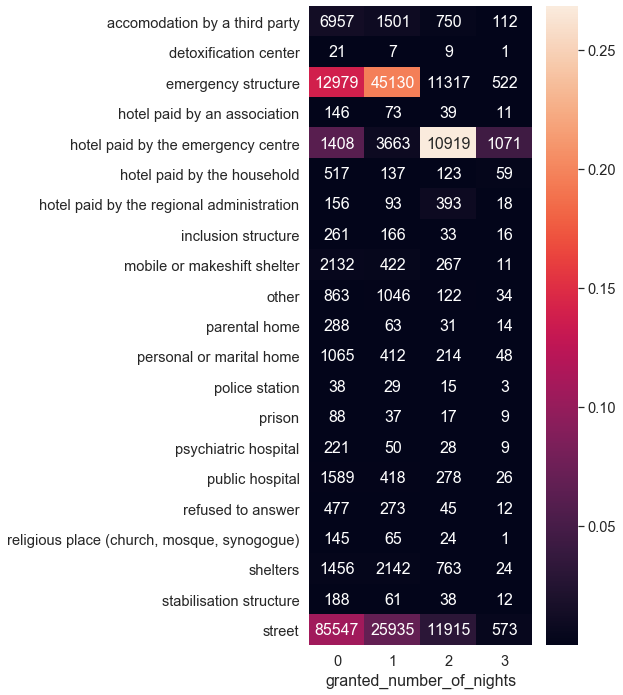

In [303]:
plot_cont(X="housing_situation_label",
Y="granted_number_of_nights",
data=requests_train)

Finally, unknown can be convert in other because not a lot of impact :

In [304]:
bol_unknown = requests_train["housing_situation_label"] == 'unknown'
requests_train.loc[bol_unknown, "housing_situation_label"] = "other"

For Test database :

In [306]:
df_test = requests_test.copy()

bol_other = df_test["housing_situation_label"] == 'other'
bol_unknown = df_test["housing_situation_label"] == 'unknown'

print("Nb. other/unknown labels before : ", 
      df_test[bol_other | bol_unknown].shape[0])
# apply conversion label from other unknow with dict
df_test.loc[bol_other | bol_unknown, 
        "housing_situation_label"] = \
    df_test[bol_other | bol_unknown] \
        ["housing_situation_2_label"].apply(fun_conv_hs)
# check 
bol_other = df_test["housing_situation_label"] == 'other'
bol_unknown = df_test["housing_situation_label"] == 'unknown'
print("Nb. other/unknown labels after : ", 
      df_test[bol_other | bol_unknown].shape[0])

Nb. other/unknown labels before :  6692
Nb. other/unknown labels after :  532


In [307]:
requests_test = df_test.copy()

In [308]:
bol_unknown = requests_test["housing_situation_label"] == 'unknown'
print("Nb. unknown before : ", requests_test[bol_unknown].shape[0])
requests_test.loc[bol_unknown, "housing_situation_label"] = "other"
bol_unknown = requests_test["housing_situation_label"] == 'unknown'
print("Nb. unknown after : ", requests_test[bol_unknown].shape[0])

Nb. unknown before :  0
Nb. unknown after :  0


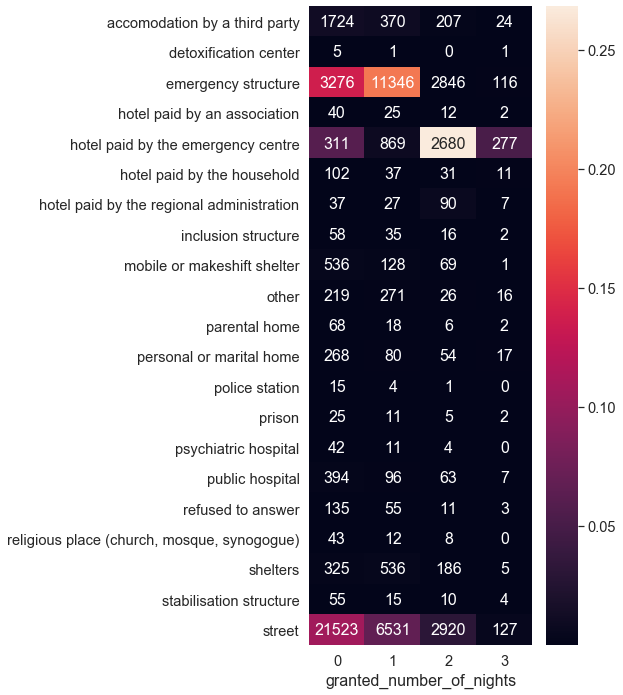

In [309]:
plot_cont(X="housing_situation_label",
Y="granted_number_of_nights",
data=requests_test)

In [310]:
# check in no Nan
bol_nan = requests_train["housing_situation_label"].isna()
print("TRAIN : Nb. nan values = ", requests_train[bol_nan].shape[0])
bol_nan = requests_test["housing_situation_label"].isna()
print("TRAIN : Nb. nan values = ", requests_test[bol_nan].shape[0])

TRAIN : Nb. nan values =  0
TRAIN : Nb. nan values =  0


=> OK cleaning done.

### child to come

In [174]:
requests_train["child_to_come"].value_counts(dropna=False)

NaN    145947
f       85878
t        6366
Name: child_to_come, dtype: int64

In [175]:
requests_train.loc[requests_train["child_to_come"].isna(),
                   "child_to_come"] = "unknown"

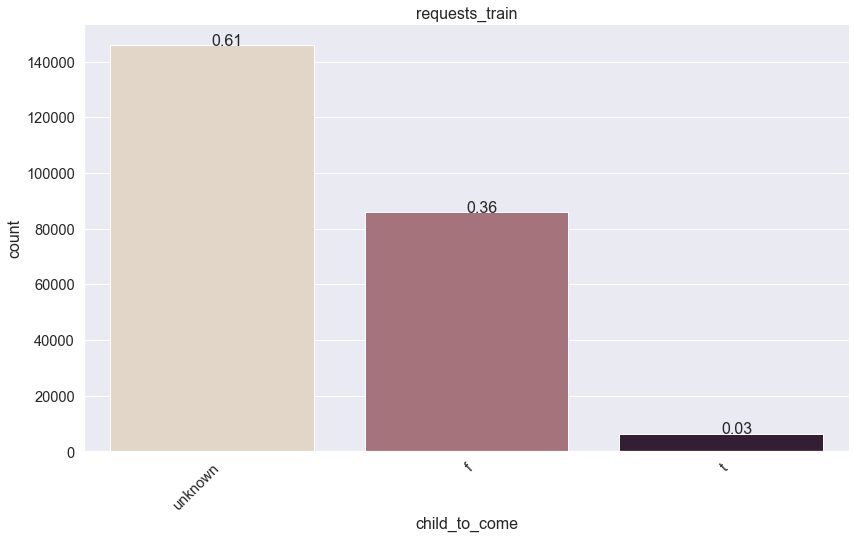

In [176]:
plot_hist_cat(x="child_to_come", data=requests_train, 
              title="requests_train")

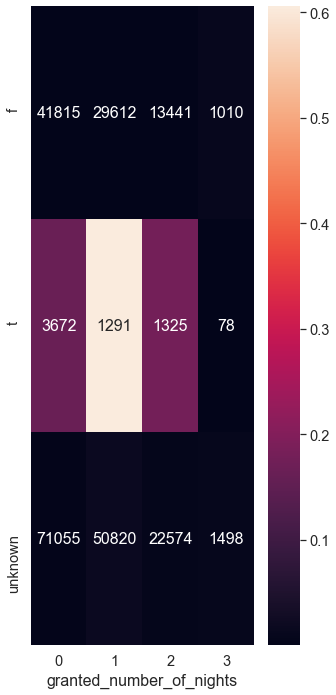

In [177]:
plot_cont(X="child_to_come", Y="granted_number_of_nights", data=requests_train)

=> dependency when True.

Find info in individuals tables : 

In [312]:
individuals_train["pregnancy"].value_counts(dropna=False)

f      372930
t       11189
NaN        14
Name: pregnancy, dtype: int64

In [313]:
def fun_pregnancy(serie_in):
    if ("t" in serie_in.tolist()):
        return "t"
    else:
        return "f"


pt_req_preg_train = pd.pivot_table(individuals_train, 
                              values='pregnancy', 
               index=['request_id'], aggfunc=fun_pregnancy)

pt_req_preg_train

,pregnancy
request_id,
0000602749161524aedd04269957e5fc,f
0000c66f6bb24e930cba6a3872d3ab02,f
0000dbd253c096eab97cab0545915ab2,f
0001826bdd626262ec2bda3a1b908aac,f
0001925b4cd4d65110638ee3d5f2f454,f
...,...
fffd7c7c22a9147bc4af4b869eb97f19,f
fffeeac2155c826f0ccc2f912c1049f9,f
fffeff160a0bf8c160c9e63436273cec,f


In [314]:
pt_req_preg_train["pregnancy"].value_counts(dropna=False)

f    227012
t     11179
Name: pregnancy, dtype: int64

Same for Test :

In [315]:
individuals_test["pregnancy"].value_counts(dropna=False)

f      92839
t       2798
NaN        4
Name: pregnancy, dtype: int64

In [316]:
pt_req_preg_test = pd.pivot_table(individuals_test, 
                              values='pregnancy', 
               index=['request_id'], aggfunc=fun_pregnancy)

pt_req_preg_test

,pregnancy
request_id,
00025115a1823cf8dc4e405fac55aa08,f
000329aa7e358635d26ff2d82a3f51d9,f
00035ca76ed77fd146fbd433fdccd8a5,f
0004db4b2bf9997bbd68d59c5c4d65a5,f
00072464a3949529d9093a7622806527,f
...,...
fffd6850c8daf68dcdf737647952f40d,f
fffe858cbae1fcf6093a9676d81119d9,t
fffec8a1dff845182d68e56ed8329a37,f


Add data to request tables

In [317]:
df_test = requests_train.copy()
df_test = df_test.join(pt_req_preg_train, on="request_id")
df_test.head().T

,0,1,2,3,4
request_id,130667d2964de43c511d0ead7ac66b33,b1cd62fcf24eebb0f685d5eaf55317a8,12cc0a18890bd4959fe42df3ae58838e,ae2d5b4dc181d29e430132f145da1556,d13a17ce36c832514fda2464e11c4a9f
animal_presence,f,f,f,f,f
answer_creation_date,2019-02-11 22:30:00,2019-02-12 09:00:00,2019-02-01 21:00:00,2019-02-25 15:12:05.037,2019-02-20 09:59:20.603
child_situation,-1,-1,-1,-1,-1
child_to_come,unknown,unknown,unknown,unknown,unknown
district,85,85,59,50,93
granted_number_of_nights,1,1,1,2,2
group_composition_id,10,10,80,20,60
group_composition_label,man alone,man alone,isolated child/underage,woman alone,group with child(ren)
group_creation_date,2018-05-03 12:10:40.416,2019-03-07 12:11:08.545,2019-03-13 12:54:15.887,2018-10-09 14:37:29.773,2018-10-02 10:47:36.931


In [318]:
requests_train = df_test.copy()

In [319]:
df_test = requests_test.copy()
df_test = df_test.join(pt_req_preg_test, on="request_id")
df_test.head().T

,0,1,2,3,4
request_id,6a94e460b649033f78a6b136815364af,732820e77e68d6b8ac6da919b7c08da1,415696df2fef0b6a4d7e07b36d12dc7f,545fc3ead390446a3b08b71a44188d70,2fd26167f6d41e6422962887f42eef90
animal_presence,f,f,f,f,f
answer_creation_date,2019-02-27 08:21:23.301,2019-02-27 15:06:56.757,2019-02-27 09:53:34.537,2019-02-27 20:19:11.887,2019-02-27 11:31:58.067
child_situation,-1,-1,-1,-1,-1
child_to_come,NaN,NaN,NaN,NaN,NaN
district,60,35,100,95,13
granted_number_of_nights,0,0,0,0,0
group_composition_id,40,10,20,10,10
group_composition_label,single mother with child(ren),man alone,woman alone,man alone,man alone
group_creation_date,2019-01-23 11:26:20.206,2019-02-25 12:20:46.138,2019-02-27 09:54:57.263,2019-01-30 17:41:20.532,2018-12-11 16:54:03.526


In [320]:
requests_test = df_test.copy()

Check validity : 

if pregnancy True, child_to_come True ?

In [333]:
requests_train[requests_train["pregnancy"] == 't'] \
    ["child_to_come"].value_counts()

unknown    5375
t          4414
f          1390
Name: child_to_come, dtype: int64

In [335]:
requests_train[requests_train["pregnancy"] == 'f'] \
    ["child_to_come"].value_counts()

unknown    140572
f           84488
t            1952
Name: child_to_come, dtype: int64

In [338]:
requests_train[requests_train["child_to_come"] == 't'] \
    ["pregnancy"].value_counts()

t    4414
f    1952
Name: pregnancy, dtype: int64

In [339]:
requests_train[requests_train["child_to_come"] == 'f'] \
    ["pregnancy"].value_counts()

f    84488
t     1390
Name: pregnancy, dtype: int64

In [342]:
requests_train[requests_train["child_to_come"] == 'unknown'] \
    ["pregnancy"].value_counts()

f    140572
t      5375
Name: pregnancy, dtype: int64

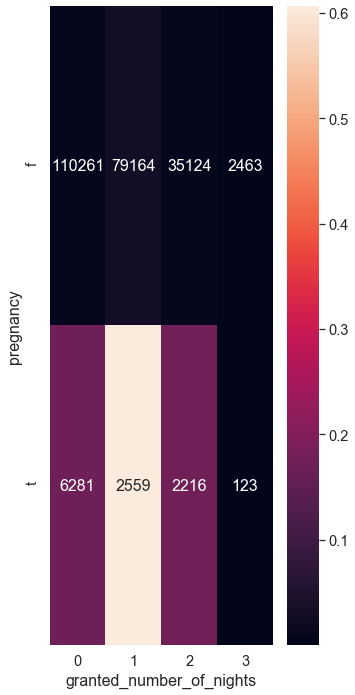

In [343]:
plot_cont(X="pregnancy", Y="granted_number_of_nights", data=requests_train)

=> We can take "pregnancy" as feature because less nan values and keep information
(altough data "child_to_come" is not exactly the same as pregnancy)

### Localization

In [347]:
#individuals_train
requests_train["town"].value_counts(dropna=False)

NaN              159959
Saint-Étienne      4549
Amiens             3900
Nantes             3820
Lyon               3643
                  ...  
Étreux                1
Rouhling              1
Vieux-Berquin         1
Le Cannet             1
Bornel                1
Name: town, Length: 1117, dtype: int64

In [351]:
requests_train[requests_train["town"].notna()].shape[0]

78232

In [353]:
geolocator = Nominatim(user_agent="data-science-test")
location = geolocator.geocode("Bornel")
print(location.address)

Bournel, Villeneuve-sur-Lot, Lot-et-Garonne, Nouvelle-Aquitaine, France métropolitaine, 47210, France


In [355]:
location.raw

{'place_id': 235662944,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'osm_type': 'relation',
 'osm_id': 3230607,
 'boundingbox': ['44.6087203', '44.6542293', '0.6489101', '0.7155423'],
 'lat': '44.6197337',
 'lon': '0.6706425',
 'display_name': 'Bournel, Villeneuve-sur-Lot, Lot-et-Garonne, Nouvelle-Aquitaine, France métropolitaine, 47210, France',
 'class': 'boundary',
 'type': 'administrative',
 'importance': 0.5076303593361482,
 'icon': 'https://nominatim.openstreetmap.org/images/mapicons/poi_boundary_administrative.p.20.png'}

In [356]:
requests_train["district"].value_counts(dropna=False)

70        12400
68        11442
13        10567
60         9732
93         7985
          ...  
19           21
98           19
48            5
315770        4
315842        1
Name: district, Length: 102, dtype: int64

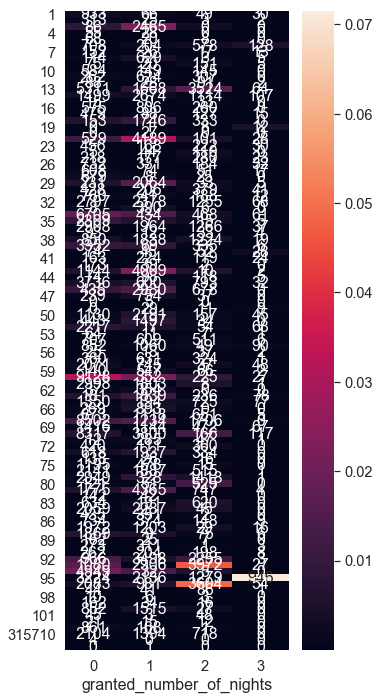

In [357]:
plot_cont(X="district", Y="granted_number_of_nights", data=requests_train)

=> There is some information into town because distribution of number of nights depends on town.

Check if district = french "departement" :

In [362]:
df_dep = pd.read_csv(filepath_or_buffer=PATH_TO_DEP,
                             sep=',',
                             low_memory=False,
                             error_bad_lines=False)
df_dep

,id,region_code,code,name,slug
0,1,84,01,Ain,ain
1,2,32,02,Aisne,aisne
2,3,84,03,Allier,allier
3,4,93,04,Alpes-de-Haute-Provence,alpes de haute provence
4,5,93,05,Hautes-Alpes,hautes alpes
...,...,...,...,...,...
104,105,COM,984,Terres australes et antarctiques françaises,terres australes et antarctiques francaises
105,106,COM,986,Wallis et Futuna,wallis et futuna
106,107,COM,987,Polynésie française,polynesie francaise
107,108,COM,988,Nouvelle-Calédonie,nouvelle caledonie


In [366]:
df_dep["code"].tolist()

['01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '2A',
 '2B',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '971',
 '972',
 '973',
 '974',
 '976',
 '975',
 '977',
 '978',
 '984',
 '986',
 '987',
 '988',
 '989']

In [368]:
df_cit = pd.read_csv(filepath_or_buffer=PATH_TO_CIT,
                             sep=',',
                             low_memory=False,
                             error_bad_lines=False)
df_cit

,id,department_code,insee_code,zip_code,name,slug,gps_lat,gps_lng
0,1,01,01001,1400.0,L'Abergement-Clémenciat,l abergement clemenciat,46.156782,4.924699
1,2,01,01002,1640.0,L'Abergement-de-Varey,l abergement de varey,46.010086,5.428759
2,3,01,01004,1500.0,Ambérieu-en-Bugey,amberieu en bugey,45.958409,5.375992
3,4,01,01005,1330.0,Ambérieux-en-Dombes,amberieux en dombes,46.000120,4.910602
4,5,01,01006,1300.0,Ambléon,ambleon,45.746427,5.602492
...,...,...,...,...,...,...,...,...
35848,35849,988,NaN,98831.0,Touho,touho,-20.780538,165.232815
35849,35850,988,NaN,98833.0,Voh,voh,-20.949963,164.687186
35850,35851,988,NaN,98834.0,Yaté,yate,-22.159370,166.944270
35851,35852,988,NaN,98818.0,Kouaoua,kouaoua,-21.396181,165.828447


In [372]:
requests_train[requests_train["town"] == "Grigny"]["district"].value_counts()

92    375
95      1
Name: district, dtype: int64

In [373]:
df_cit[df_cit["name"] == "Grigny"]["department_code"]

24442    62
27652    69
35182    91
Name: department_code, dtype: object

In [374]:
df_cit[df_cit["name"] == "Grigny"]

,id,department_code,insee_code,zip_code,name,slug,gps_lat,gps_lng
24442,24443,62,62388,62140.0,Grigny,grigny,50.385548,2.058399
27652,27653,69,69096,69520.0,Grigny,grigny,45.612089,4.784562
35182,35183,91,91286,91350.0,Grigny,grigny,48.653582,2.388497


In [377]:
requests_train[requests_train["town"].notna()]["town"]

12                     Reims
14                    Rennes
23                  Bordeaux
26          Corbeil-Essonnes
31        Bruay-la-Buissière
                 ...        
238179        Roissy-en-Brie
238181               Quimper
238184            Versailles
238189                Grigny
238190         Aubervilliers
Name: town, Length: 78232, dtype: object

In [378]:
requests_train[requests_train["town"] == "Reims"]["district"].value_counts()

52    1131
58      22
64      16
8        7
57       3
61       2
45       2
29       2
13       2
93       1
70       1
68       1
60       1
18       1
6        1
2        1
Name: district, dtype: int64

In [379]:
df_cit[df_cit["name"] == "Reims"]["department_code"]

19040    51
Name: department_code, dtype: object

=> NOK : district number is different than departement code.

Check if some district doesn't have any towns in database : 

Find most used town for each District 

In [487]:
def fun_find_town(list_in):
    val_c = list_in.value_counts(dropna=True)
    if len(val_c) > 0:
        return val_c.index[0]
    else:
        return np.nan 
    
pt_dis_town_train = pd.pivot_table(requests_train, 
                              values='town', index=['district'], 
                                   aggfunc=fun_find_town, dropna=False)
pt_dis_town_train

,town
district,
1,Lyon
2,Saint-Quentin
3,Périgueux
4,NaN
5,Metz
...,...
314550,NaN
315670,Lyon
315710,Caen


In [488]:
pt_dis_town_train.shape[0]

102

In [489]:
print("Nb district without town : ", 
      pt_dis_town_train[pt_dis_town_train["town"].isna()].shape[0])

Nb district without town :  5


In [490]:
pt_dis_town_train[pt_dis_town_train["town"].isna()]

,town
district,
4,NaN
9,NaN
101,NaN
314550,NaN
315842,NaN


In [491]:
pt_dis_town_test = pd.pivot_table(requests_test, 
                              values='town', index=['district'], 
                                   aggfunc=fun_find_town)
pt_dis_town_test

,town
district,
1,Lyon
2,Soissons
3,Périgueux
5,Marseille
6,Marseille
...,...
99,Cayenne
100,Saint-Denis
315670,Angoulême


In [492]:
print("Nb district without town in Test : ", 
      pt_dis_town_test[pt_dis_town_test["town"].isna()].shape[0])

Nb district without town in Test :  0


In [493]:
pt_dis_town_test[pt_dis_town_test["town"].isna()]

,town
district,


In [494]:
pt_dis_town = pt_dis_town_train.join(pt_dis_town_test, on="district", 
                                     rsuffix='_test')

In [495]:
pt_dis_town

,town,town_test
district,,
1,Lyon,Lyon
2,Saint-Quentin,Soissons
3,Périgueux,Périgueux
4,NaN,NaN
5,Metz,Marseille
...,...,...
314550,NaN,NaN
315670,Lyon,Angoulême
315710,Caen,Caen


Check if we can add information with Test data ?

In [496]:
pt_dis_town[pt_dis_town["town"].isna() & pt_dis_town["town_test"].notna()]

,town,town_test
district,,


=> NO : no info about town into district 

We can try to reduce categorical data (102 dimensions) into area geographical data  (regions)

In [497]:
df_reg = pd.read_csv(filepath_or_buffer=PATH_TO_REG,
                             sep=',',
                             low_memory=False,
                             error_bad_lines=False)
df_reg


,id,code,name,slug
0,1,01,Guadeloupe,guadeloupe
1,2,02,Martinique,martinique
2,3,03,Guyane,guyane
3,4,04,La Réunion,la reunion
4,5,06,Mayotte,mayotte
5,6,11,Île-de-France,ile de france
6,7,24,Centre-Val de Loire,centre val de loire
7,8,27,Bourgogne-Franche-Comté,bourgogne franche comte
8,9,28,Normandie,normandie
9,10,32,Hauts-de-France,hauts de france


In [498]:
df_cit

,id,department_code,insee_code,zip_code,name,slug,gps_lat,gps_lng
0,1,01,01001,1400.0,L'Abergement-Clémenciat,l abergement clemenciat,46.156782,4.924699
1,2,01,01002,1640.0,L'Abergement-de-Varey,l abergement de varey,46.010086,5.428759
2,3,01,01004,1500.0,Ambérieu-en-Bugey,amberieu en bugey,45.958409,5.375992
3,4,01,01005,1330.0,Ambérieux-en-Dombes,amberieux en dombes,46.000120,4.910602
4,5,01,01006,1300.0,Ambléon,ambleon,45.746427,5.602492
...,...,...,...,...,...,...,...,...
35848,35849,988,NaN,98831.0,Touho,touho,-20.780538,165.232815
35849,35850,988,NaN,98833.0,Voh,voh,-20.949963,164.687186
35850,35851,988,NaN,98834.0,Yaté,yate,-22.159370,166.944270
35851,35852,988,NaN,98818.0,Kouaoua,kouaoua,-21.396181,165.828447


In [499]:
pt_dis_town

,town,town_test
district,,
1,Lyon,Lyon
2,Saint-Quentin,Soissons
3,Périgueux,Périgueux
4,NaN,NaN
5,Metz,Marseille
...,...,...
314550,NaN,NaN
315670,Lyon,Angoulême
315710,Caen,Caen


In [500]:
df_cit.filter(items=["name","department_code"]). \
                 set_index("name")

,department_code
name,
L'Abergement-Clémenciat,01
L'Abergement-de-Varey,01
Ambérieu-en-Bugey,01
Ambérieux-en-Dombes,01
Ambléon,01
...,...
Touho,988
Voh,988
Yaté,988


In [501]:
pt_dis_town["district"] = pt_dis_town.index
pt_dis_town

,town,town_test,district
district,,,
1,Lyon,Lyon,1
2,Saint-Quentin,Soissons,2
3,Périgueux,Périgueux,3
4,NaN,NaN,4
5,Metz,Marseille,5
...,...,...,...
314550,NaN,NaN,314550
315670,Lyon,Angoulême,315670
315710,Caen,Caen,315710


In [502]:
pt_dis_town

,town,town_test,district
district,,,
1,Lyon,Lyon,1
2,Saint-Quentin,Soissons,2
3,Périgueux,Périgueux,3
4,NaN,NaN,4
5,Metz,Marseille,5
...,...,...,...
314550,NaN,NaN,314550
315670,Lyon,Angoulême,315670
315710,Caen,Caen,315710


In [503]:
df_cit[df_cit["name"] == "Lyon"]

,id,department_code,insee_code,zip_code,name,slug,gps_lat,gps_lng
27678,27679,69,69123,69001.0,Lyon,lyon,45.771292,4.828083
27679,27680,69,69123,69002.0,Lyon,lyon,45.747711,4.824100
27680,27681,69,69123,69003.0,Lyon,lyon,45.758260,4.855387
27681,27682,69,69123,69004.0,Lyon,lyon,45.780952,4.824349
27682,27683,69,69123,69005.0,Lyon,lyon,45.758262,4.799075
27683,27684,69,69123,69006.0,Lyon,lyon,45.775107,4.850198
27684,27685,69,69123,69007.0,Lyon,lyon,45.730425,4.839938
27685,27686,69,69123,69008.0,Lyon,lyon,45.731539,4.869617
27686,27687,69,69123,69009.0,Lyon,lyon,45.769942,4.803718


In [504]:
def fun_take_first(list_in):
    return list_in.values[0]

pt_town_dep = pd.pivot_table(df_cit,values='department_code', index=['name'], 
               aggfunc=fun_take_first)
pt_town_dep

,department_code
name,
Aast,64
Abainville,55
Abancourt,59
Abaucourt,54
Abaucourt-Hautecourt,55
...,...
Îles Saint-Paul et Nouvelle-Amsterdam,984
Îles Éparses de l'océan Indien,984
Œting,57


In [505]:
pt_dis_town = pt_dis_town.join(pt_town_dep, on="town", how="inner")
pt_dis_town

,town,town_test,district,department_code
district,,,,
1,Lyon,Lyon,1,69
7,Lyon,Lyon,7,69
22,Lyon,Lyon,22,69
70,Lyon,Lyon,70,69
72,Lyon,Lyon,72,69
...,...,...,...,...
96,Cergy,Cergy,96,95
97,Pointe-à-Pitre,Pointe-à-Pitre,97,971
98,Le Lamentin,NaN,98,972


In [514]:
df_dep.head()

,id,region_code,code,name,slug
0,1,84,01,Ain,ain
1,2,32,02,Aisne,aisne
2,3,84,03,Allier,allier
3,4,93,04,Alpes-de-Haute-Provence,alpes de haute provence
4,5,93,05,Hautes-Alpes,hautes alpes


In [517]:
df_dep.shape[0]

109

In [518]:
df_dep["code"].nunique()

109

In [520]:
pt_dis_town = pt_dis_town.merge(df_dep.filter(items=["code", "region_code"]), 
                 left_on="department_code", right_on="code", how="inner")


In [521]:
pt_dis_town

,town,town_test,district,department_code,code,region_code
0,Lyon,Lyon,1,69,69,84
1,Lyon,Lyon,7,69,69,84
2,Lyon,Lyon,22,69,69,84
3,Lyon,Lyon,70,69,69,84
4,Lyon,Lyon,72,69,69,84
...,...,...,...,...,...,...
92,Cergy,Cergy,96,95,95,11
93,Pointe-à-Pitre,Pointe-à-Pitre,97,971,971,01
94,Le Lamentin,NaN,98,972,972,02
95,Cayenne,Cayenne,99,973,973,03


In [522]:
df_reg.head()

,id,code,name,slug
0,1,01,Guadeloupe,guadeloupe
1,2,02,Martinique,martinique
2,3,03,Guyane,guyane
3,4,04,La Réunion,la reunion
4,5,06,Mayotte,mayotte


In [524]:
pt_dis_town = pt_dis_town.merge(df_reg.filter(items=["code", "name"]), 
                 left_on="region_code", right_on="code", how="inner")
pt_dis_town

,town,town_test,district,department_code,code_x,region_code,code_y,name
0,Lyon,Lyon,1,69,69,84,84,Auvergne-Rhône-Alpes
1,Lyon,Lyon,7,69,69,84,84,Auvergne-Rhône-Alpes
2,Lyon,Lyon,22,69,69,84,84,Auvergne-Rhône-Alpes
3,Lyon,Lyon,70,69,69,84,84,Auvergne-Rhône-Alpes
4,Lyon,Lyon,72,69,69,84,84,Auvergne-Rhône-Alpes
...,...,...,...,...,...,...,...,...
92,Créteil,Créteil,95,94,94,11,11,Île-de-France
93,Cergy,Cergy,96,95,95,11,11,Île-de-France
94,Pointe-à-Pitre,Pointe-à-Pitre,97,971,971,01,01,Guadeloupe
95,Le Lamentin,NaN,98,972,972,02,02,Martinique


In [525]:
pt_dis_town["name"].nunique()

16

In [528]:
requests_train = requests_train.merge(pt_dis_town.filter(items=["district", "name"]), 
                 left_on="district", right_on="district", how="inner")

In [534]:
requests_train.rename(columns={"name": "region"},inplace=True)
requests_train

,request_id,animal_presence,answer_creation_date,child_situation,child_to_come,district,granted_number_of_nights,group_composition_id,group_composition_label,group_creation_date,...,request_backoffice_creator_id,request_creation_date,requester_type,social_situation_id,town,victim_of_violence,victim_of_violence_type,housing_situation_2_label,pregnancy,region
0,130667d2964de43c511d0ead7ac66b33,f,2019-02-11 22:30:00,-1,unknown,85,1,10,man alone,2018-05-03 12:10:40.416,...,eecd6110b7e9157e6423428b22a28159,2019-02-11 22:30:00,third party,9a84febc47fedaf2c81d7c755e9edc85,NaN,f,NaN,on the street,f,Provence-Alpes-Côte d'Azur
1,b1cd62fcf24eebb0f685d5eaf55317a8,f,2019-02-12 09:00:00,-1,unknown,85,1,10,man alone,2019-03-07 12:11:08.545,...,eecd6110b7e9157e6423428b22a28159,2019-02-12 09:00:00,user,11f64f0547e855c5c59329b9edc63063,NaN,f,NaN,on the street,f,Provence-Alpes-Côte d'Azur
2,eae4762c0c04f515269ab781acd72767,f,2019-02-22 13:00:00,-1,unknown,85,0,10,man alone,2019-04-02 08:30:02.818,...,eecd6110b7e9157e6423428b22a28159,2019-02-22 13:00:00,user,c459d43859066e19173d86d5513ba963,NaN,f,NaN,on the street,f,Provence-Alpes-Côte d'Azur
3,61d89004239ffae3a210f94f74e052f9,f,2019-02-05 13:00:00,-1,unknown,85,0,10,man alone,2018-08-01 13:33:57.065,...,eecd6110b7e9157e6423428b22a28159,2019-02-05 13:00:00,user,faac8ee0335e9e8aa96b56febc3b4ff0,NaN,f,NaN,on the street,f,Provence-Alpes-Côte d'Azur
4,3ab1f3e0f31b81d24ac5dc06a7d02184,f,2019-02-09 09:00:00,-1,f,85,0,10,man alone,2017-12-15 18:22:15.632,...,391a792218fb6d236cc2954e36524998,2019-02-09 09:00:00,user,9553a0d03dff3fec573b10f41e5d4772,NaN,f,NaN,"public instition (hospital, retirement home)",f,Provence-Alpes-Côte d'Azur
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237707,07192a414a941379d5184f0413671b85,f,2019-03-08 10:58:49.861,-1,f,48,1,10,man alone,2019-03-08 10:05:13.490,...,9d49562ab5050e88111cf74437b13915,2019-03-08 10:58:49.861,user,4a2c607a80eba75c456693c03a89bc38,Agen,f,NaN,on the street,f,Nouvelle-Aquitaine
237708,74a63c481e265a6fa239dd0036425dcd,f,2019-03-15 10:32:01.393,-1,unknown,48,1,10,man alone,2019-01-10 17:00:36.008,...,5e2770ead3b103320731ca331a36de13,2019-03-15 10:32:01.393,user,37647a29e84f9d8e0d422be9fe69542a,NaN,f,NaN,on the street,f,Nouvelle-Aquitaine
237709,f9175af35f5bf15164bce039dca2e2a1,f,2019-01-01 09:57:00,-1,unknown,48,1,10,man alone,2019-01-09 21:48:46.655,...,5e2770ead3b103320731ca331a36de13,2019-01-01 09:57:00,user,fd58da4f9f7a7855002c4785fdf2124f,NaN,f,NaN,on the street,f,Nouvelle-Aquitaine
237710,2ef777e0cafa95371749d73acbcb805d,f,2019-01-01 15:07:00,-1,unknown,48,1,30,couple without whildren,2019-01-25 16:01:41.789,...,5e2770ead3b103320731ca331a36de13,2019-01-01 15:07:00,user,05e0f97bef2161a40e906bd609df6fb7,NaN,f,NaN,on the street,f,Nouvelle-Aquitaine


In [531]:
requests_test = requests_test.merge(pt_dis_town.filter(items=["district", "name"]), 
                 left_on="district", right_on="district", how="inner")

In [533]:
requests_test.rename(columns={"name": "region"},inplace=True)
requests_test

,request_id,animal_presence,answer_creation_date,child_situation,child_to_come,district,granted_number_of_nights,group_composition_id,group_composition_label,group_creation_date,...,request_backoffice_creator_id,request_creation_date,requester_type,social_situation_id,town,victim_of_violence,victim_of_violence_type,housing_situation_2_label,pregnancy,region
0,6a94e460b649033f78a6b136815364af,f,2019-02-27 08:21:23.301,-1,NaN,60,0,40,single mother with child(ren),2019-01-23 11:26:20.206,...,5072b10fb7d333360cf7f2f1d6d0c8a9,2019-02-27 08:21:23.301,user,83020f498b30b41f970bcc95060719e8,NaN,f,NaN,on the street,f,Hauts-de-France
1,2f6cd16f85ef7afaffab1441ef0a20ed,f,2019-02-19 07:30:39.447,-1,f,60,0,10,man alone,2018-07-30 17:39:19.208,...,2fc0be1d8e8acbc243728b6ade02e38e,2019-02-19 07:30:39.447,user,74ba01957df8c97de27fd7437c71985e,NaN,f,NaN,on the street,f,Hauts-de-France
2,108ad82e01191a37e541c875950bb7b6,f,2019-02-21 12:15:08.279,-1,NaN,60,0,30,couple without whildren,2019-01-15 15:54:53.352,...,8216aaf49d8c91ed0f00093e0de3ad1a,2019-02-21 12:15:08.279,user,b1e367414a68d789cfb239cace2edbc7,NaN,f,NaN,on the street,f,Hauts-de-France
3,b688349b7ee3a332875734926fd2a900,f,2019-02-24 15:13:08.52,-1,NaN,60,0,40,single mother with child(ren),2019-01-20 14:29:03.521,...,5072b10fb7d333360cf7f2f1d6d0c8a9,2019-02-24 15:13:08.52,user,8bc65f2640cda602aaf7706a596a6e0f,NaN,f,NaN,on the street,f,Hauts-de-France
4,a40730ea8b82cde83a8959c2ac32d7a6,f,2019-02-01 14:24:04.063,-1,NaN,60,0,10,man alone,2018-07-27 08:32:13.376,...,5072b10fb7d333360cf7f2f1d6d0c8a9,2019-02-01 14:24:04.063,user,313f99a4ca4cb05e2d1671ce90c84ffe,NaN,f,NaN,on the street,f,Hauts-de-France
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59417,37b3e77be234bb95b8ccebca979b1e77,f,2019-03-10 00:50:00,-1,NaN,21,1,40,single mother with child(ren),2019-03-11 15:22:48.319,...,9ff453633affc002249d8ac40aa2eee2,2019-03-10 00:50:00,user,81e9a6a7fb2765910d97cd3019375766,NaN,t,woman victim of domestic violence,evicted from public housing rental,f,Corse
59418,d65a23c258197b48da8c8c6c7c00a697,f,2019-01-21 09:57:00,-1,f,21,1,20,woman alone,2017-06-17 00:00:00.000,...,9ff453633affc002249d8ac40aa2eee2,2019-01-21 09:57:00,user,bc10a79c40bcc34c44bcb9d8fb025a94,Carcassonne,f,NaN,on the street,f,Corse
59419,b36302460e913d04d867412f377fd9b7,f,2019-01-07 10:47:00,30,f,21,1,10,man alone,2019-01-07 10:53:33.392,...,9ff453633affc002249d8ac40aa2eee2,2019-01-07 10:47:00,user,0280ae4b3da0cfb9a0fb1ece508ab212,Bastia,f,NaN,on the street,f,Corse
59420,6d103702603783be12af45702514674f,f,2019-03-25 17:27:34.667,30,f,315770,0,20,woman alone,2018-07-26 15:51:42.683,...,b8b2d1a25e2c069045107bc5c274ab40,2019-03-25 17:27:34.667,user,f556d1f6540a5d89c37c1d958f5ba8de,Saint-Martin,f,NaN,evicted from private housing rental,f,Occitanie


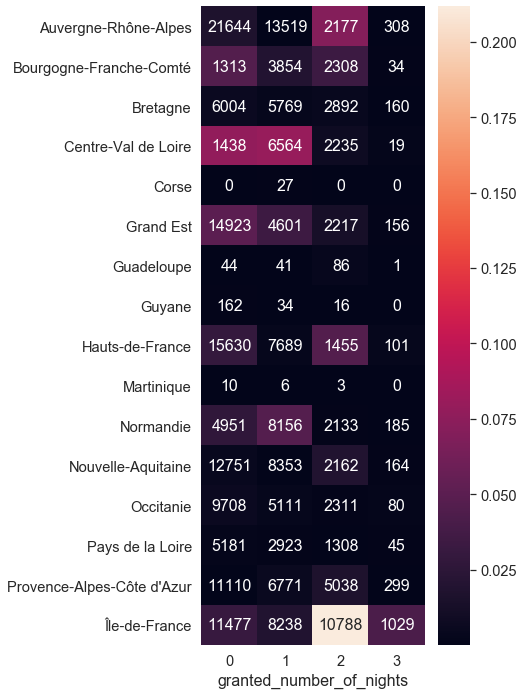

In [535]:
plot_cont(X="region",
    Y="granted_number_of_nights",
    data=requests_train)

=> OK : reduction of geolocalisation of request on regions area.

Information is still there because distribution  "granted_numer_of_nights" still depends of some regions 

In [536]:
requests_train[requests_train["region"].isna()]

,request_id,animal_presence,answer_creation_date,child_situation,child_to_come,district,granted_number_of_nights,group_composition_id,group_composition_label,group_creation_date,...,request_backoffice_creator_id,request_creation_date,requester_type,social_situation_id,town,victim_of_violence,victim_of_violence_type,housing_situation_2_label,pregnancy,region


In [537]:
requests_test[requests_test["region"].isna()]

,request_id,animal_presence,answer_creation_date,child_situation,child_to_come,district,granted_number_of_nights,group_composition_id,group_composition_label,group_creation_date,...,request_backoffice_creator_id,request_creation_date,requester_type,social_situation_id,town,victim_of_violence,victim_of_violence_type,housing_situation_2_label,pregnancy,region


### long_term_housing_request

In [540]:
requests_train["long_term_housing_request"].value_counts(dropna=False)

NaN    165080
f       60383
t       12249
Name: long_term_housing_request, dtype: int64

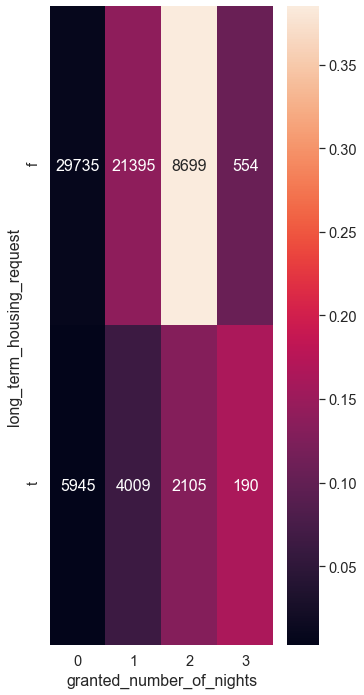

In [541]:
plot_cont(X="long_term_housing_request",
    Y="granted_number_of_nights",
    data=requests_train)


We can try to replace NaN by 'f' (false) :

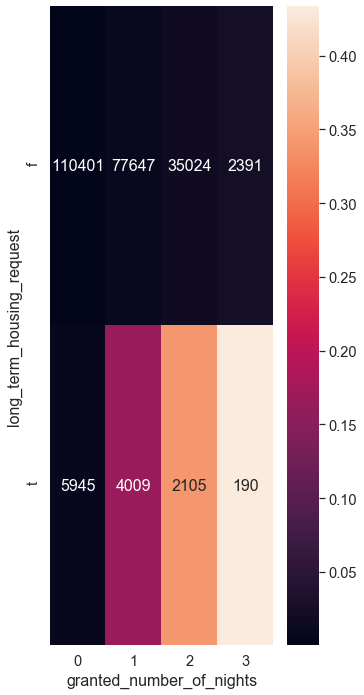

In [543]:
df_test = requests_train.copy()

df_test.loc[df_test["long_term_housing_request"].isna(), \
    "long_term_housing_request"] = 'f'

plot_cont(X="long_term_housing_request",
    Y="granted_number_of_nights",
    data=df_test)

=> NOK : Change too much initial information

So we keep unknown data : 

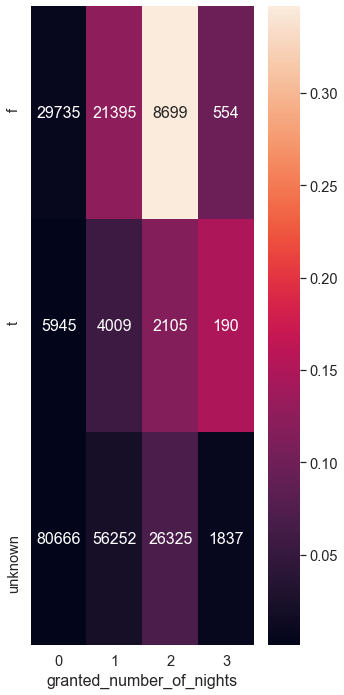

In [544]:
df_test = requests_train.copy()

df_test.loc[df_test["long_term_housing_request"].isna(), \
    "long_term_housing_request"] = 'unknown'

plot_cont(X="long_term_housing_request",
    Y="granted_number_of_nights",
    data=df_test)

In [546]:
requests_train = df_test.copy()

=> OK : information are kept

Doing the same for Test :

In [547]:
requests_test["long_term_housing_request"].value_counts(dropna=False)

NaN    41131
f      15244
t       3047
Name: long_term_housing_request, dtype: int64

In [548]:
df_test = requests_test.copy()
df_test.loc[df_test["long_term_housing_request"].isna(), \
    "long_term_housing_request"] = 'unknown'
requests_test = df_test.copy()

### victim_of_violence_type

In [549]:
requests_train["victim_of_violence_type"].value_counts(dropna=False)

NaN                                  233718
woman                                  2171
woman victim of domestic violence      1270
man                                     320
family                                  162
man victim of domestic violence          41
child                                    30
Name: victim_of_violence_type, dtype: int64

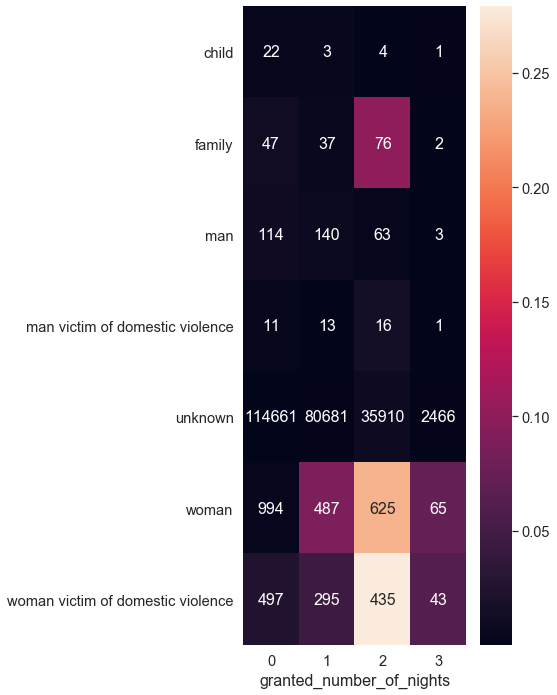

In [550]:
df_test = requests_train.copy()
df_test.loc[df_test["victim_of_violence_type"].isna(), \
    "victim_of_violence_type"] = 'unknown'

plot_cont(X="victim_of_violence_type",
    Y="granted_number_of_nights",
    data=df_test)

In [551]:
requests_train = df_test.copy()

In [565]:
requests_train["victim_of_violence"].value_counts(dropna=False)

f    233424
t      4288
Name: victim_of_violence, dtype: int64

In [567]:
bol_unknown = requests_train["victim_of_violence_type"] != "unknown"

requests_train[bol_unknown]["victim_of_violence"].value_counts(dropna=False)

t    3994
Name: victim_of_violence, dtype: int64

To reduce dimension, We can add a label to category "victim_of_violence_type" : 'f' for no violence : 

In [571]:
bol_false = requests_train["victim_of_violence"] == 'f'
requests_train[bol_false]["victim_of_violence_type"].value_counts()

unknown    233424
Name: victim_of_violence_type, dtype: int64

In [572]:
requests_train.loc[bol_false, "victim_of_violence_type"] = "f"

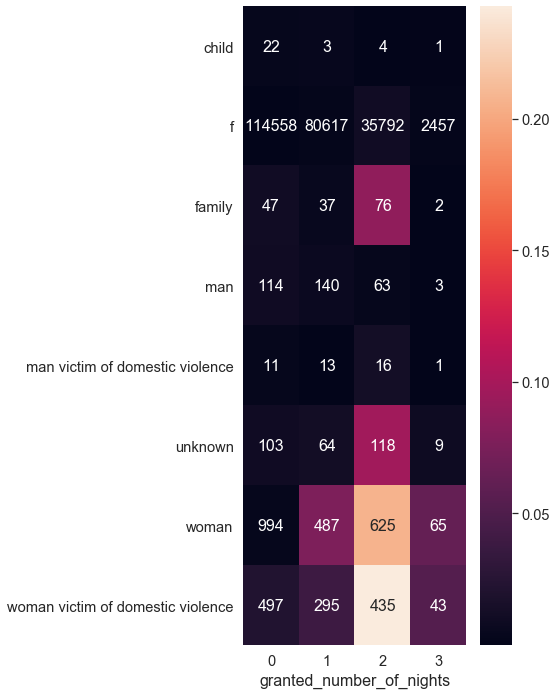

In [573]:
plot_cont(X="victim_of_violence_type",
    Y="granted_number_of_nights",
    data=requests_train)

In [552]:
df_test = requests_test.copy()
df_test.loc[df_test["victim_of_violence_type"].isna(), \
    "victim_of_violence_type"] = 'unknown'
requests_test = df_test.copy()

In [558]:
requests_test["victim_of_violence"].value_counts(dropna=False)

f      58381
t       1040
NaN        1
Name: victim_of_violence, dtype: int64

=> We correct only one data NaN : 

In [559]:
requests_test.loc[requests_test["victim_of_violence"].isna(), 
                 "victim_of_violence"] = 'f'

In [560]:
requests_test["victim_of_violence"].value_counts(dropna=False)

f    58382
t     1040
Name: victim_of_violence, dtype: int64

In [568]:
bol_unknown = requests_test["victim_of_violence_type"] != "unknown"

requests_test[bol_unknown]["victim_of_violence"].value_counts(dropna=False)

t    962
Name: victim_of_violence, dtype: int64

In [574]:
bol_false = requests_test["victim_of_violence"] == 'f'
requests_test[bol_false]["victim_of_violence_type"].value_counts()

unknown    58382
Name: victim_of_violence_type, dtype: int64

In [575]:
requests_test.loc[bol_false, "victim_of_violence_type"] = "f"

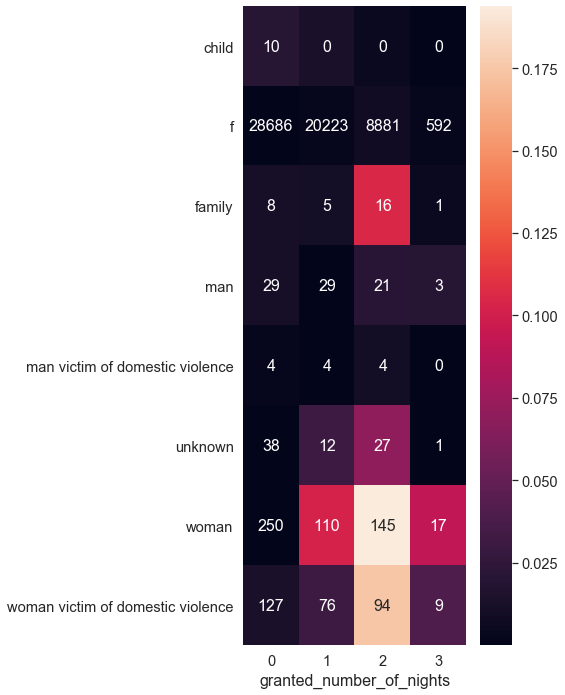

In [577]:
plot_cont(X="victim_of_violence_type",
    Y="granted_number_of_nights",
    data=requests_test)

,nb_missing,ratio
request_id,0,0.000000
housing_situation_2_label,0,0.000000
victim_of_violence_type,0,0.000000
victim_of_violence,0,0.000000
social_situation_id,0,0.000000
requester_type,0,0.000000
request_creation_date,0,0.000000
request_backoffice_creator_id,0,0.000000
number_of_underage,0,0.000000
long_term_housing_request,0,0.000000


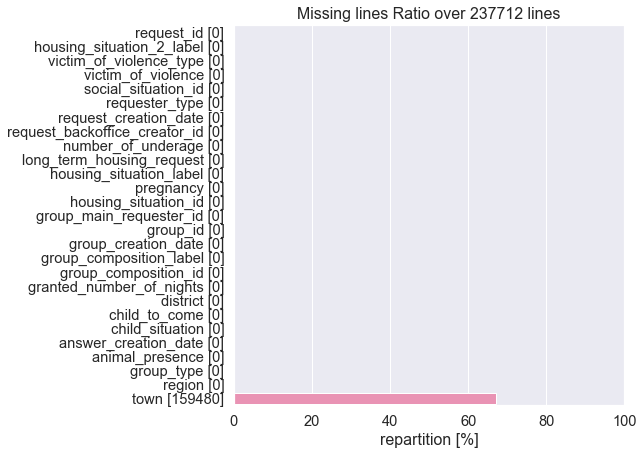

In [578]:
display_missing(requests_train)

,nb_missing,ratio
request_id,0,0.000000
housing_situation_2_label,0,0.000000
victim_of_violence_type,0,0.000000
victim_of_violence,0,0.000000
social_situation_id,0,0.000000
requester_type,0,0.000000
request_creation_date,0,0.000000
request_backoffice_creator_id,0,0.000000
number_of_underage,0,0.000000
long_term_housing_request,0,0.000000


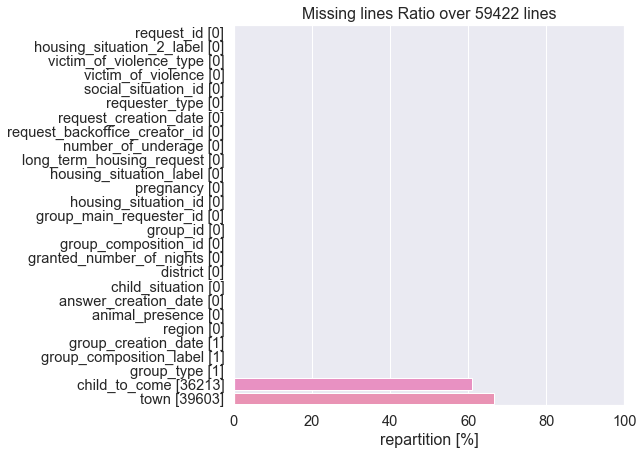

In [579]:
display_missing(requests_test)

=> OK because we will use "pregnancy" & "region" instead of "child_to_come" & "town"

### group_type

In [581]:
requests_train["group_type"].value_counts(dropna=False)

individual    170720
group          66992
Name: group_type, dtype: int64

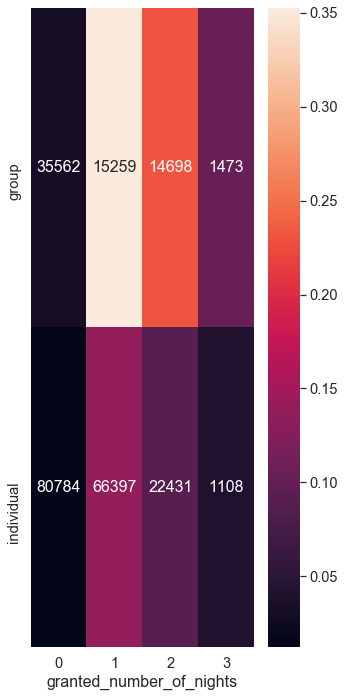

In [597]:
plot_cont(X="group_type",
    Y="granted_number_of_nights",
    data=requests_train)

=> group_type can be a feature 

### Children 

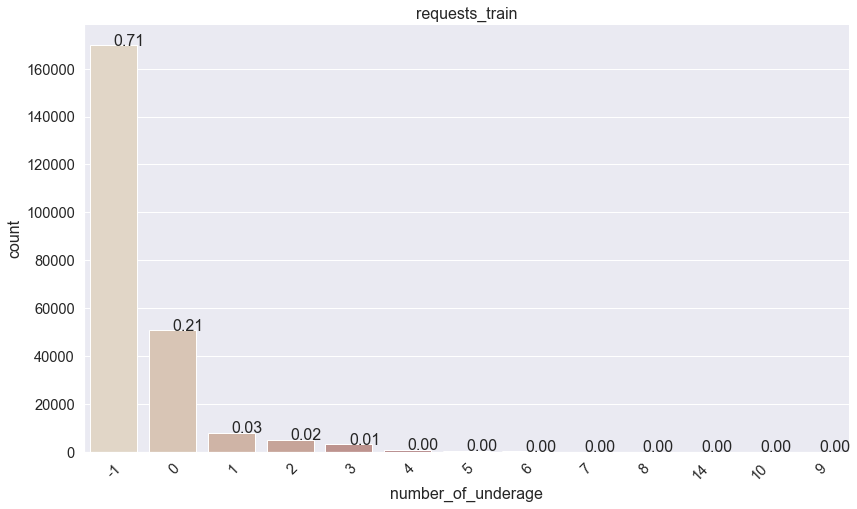

In [599]:
plot_hist_cat(x="number_of_underage", data=requests_train, 
              title="requests_train")

In [598]:
requests_train["number_of_underage"].value_counts()

-1     169792
 0      50699
 1       7907
 2       4954
 3       3013
 4        794
 5        379
 6         91
 7         70
 8          7
 14         2
 10         2
 9          2
Name: number_of_underage, dtype: int64

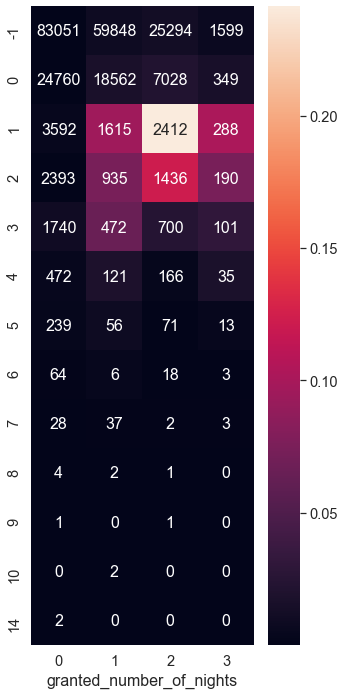

In [600]:
plot_cont(X="number_of_underage",
    Y="granted_number_of_nights",
    data=requests_train)

In [583]:
individuals_train.head().T

,0,1,2,3,4
request_id,130667d2964de43c511d0ead7ac66b33,b1cd62fcf24eebb0f685d5eaf55317a8,12cc0a18890bd4959fe42df3ae58838e,ae2d5b4dc181d29e430132f145da1556,d13a17ce36c832514fda2464e11c4a9f
individual_id,b24a8cfaaf3663bac45ca3bcd24f0b36,eef783d1bda82661a751c12c34aff8c2,927b6fa58d6be263c411332835b11fec,94181d5cf4a56cc84d12677df84e2e03,e79d2e3f9ace50049f1796c098008c13
housing_situation_2_id,20,20,20,20,35
housing_situation_2_label,on the street,on the street,on the street,on the street,hotel paid by the emergency structure
birth_month,5,5,1,7,9
birth_year,1977,1980,2003,1986,1980
childcare_center_supervision,NaN,NaN,NaN,NaN,NaN
disabled_worker_certification,NaN,NaN,NaN,NaN,NaN
gender,male,male,male,female,female
individual_creation_date,2018-01-29,2019-03-07,2019-03-13,2018-10-09,2017-06-22


In [589]:
individuals_train["childcare_center_supervision"].value_counts(dropna=False)

NaN    378254
f        3021
t        2858
Name: childcare_center_supervision, dtype: int64

In [590]:
individuals_train["individual_role_2_label"].value_counts(dropna=False)

isolated adult                160791
child/underage with family     95237
partner                        54544
husband/spouse                 25758
isolated parent                24180
other                           9268
family member                   8933
isolated underage/child         5367
NaN                               55
Name: individual_role_2_label, dtype: int64

In [596]:
bol_child_role = (individuals_train["individual_role_2_label"] \
    == "child/underage with family") | \
    (individuals_train["individual_role_2_label"] == "isolated underage/child")



individuals_train[bol_child_role]["childcare_center_supervision"] \
    .value_counts(dropna=False)

NaN    100552
t          38
f          14
Name: childcare_center_supervision, dtype: int64

In [601]:
individuals_train[individuals_train["childcare_center_supervision"] == \
                 't']["individual_role_2_label"] \
    .value_counts(dropna=False)

partner                       1093
isolated adult                1017
isolated parent                415
husband/spouse                 213
other                           73
child/underage with family      38
family member                    9
Name: individual_role_2_label, dtype: int64

In [602]:
#pt_req individuals_train["childcare_center_supervision"]

def fun_find_one_true(serie_in):
    if ("t" in serie_in.tolist()):
        return "t"
    else:
        return "f"


pt_req_cccs_train = pd.pivot_table(individuals_train, 
                              values='childcare_center_supervision', 
               index=['request_id'], aggfunc=fun_find_one_true)

pt_req_cccs_train

,childcare_center_supervision
request_id,
0000602749161524aedd04269957e5fc,f
0000c66f6bb24e930cba6a3872d3ab02,f
0000dbd253c096eab97cab0545915ab2,f
0001826bdd626262ec2bda3a1b908aac,f
0001925b4cd4d65110638ee3d5f2f454,f
...,...
fffd7c7c22a9147bc4af4b869eb97f19,f
fffeeac2155c826f0ccc2f912c1049f9,f
fffeff160a0bf8c160c9e63436273cec,f


In [603]:
pt_req_cccs_train["childcare_center_supervision"].value_counts(dropna=False)

f    235333
t      2858
Name: childcare_center_supervision, dtype: int64

In [604]:
df_test = requests_train.copy()
df_test = df_test.join(pt_req_cccs_train, on="request_id")
df_test.head().T

,0,1,2,3,4
request_id,130667d2964de43c511d0ead7ac66b33,b1cd62fcf24eebb0f685d5eaf55317a8,eae4762c0c04f515269ab781acd72767,61d89004239ffae3a210f94f74e052f9,3ab1f3e0f31b81d24ac5dc06a7d02184
animal_presence,f,f,f,f,f
answer_creation_date,2019-02-11 22:30:00,2019-02-12 09:00:00,2019-02-22 13:00:00,2019-02-05 13:00:00,2019-02-09 09:00:00
child_situation,-1,-1,-1,-1,-1
child_to_come,unknown,unknown,unknown,unknown,f
district,85,85,85,85,85
granted_number_of_nights,1,1,0,0,0
group_composition_id,10,10,10,10,10
group_composition_label,man alone,man alone,man alone,man alone,man alone
group_creation_date,2018-05-03 12:10:40.416,2019-03-07 12:11:08.545,2019-04-02 08:30:02.818,2018-08-01 13:33:57.065,2017-12-15 18:22:15.632


In [605]:
requests_train  = df_test.copy()

Same For Test : 

In [609]:
pt_req_cccs_test = pd.pivot_table(individuals_test, 
                              values='childcare_center_supervision', 
               index=['request_id'], aggfunc=fun_find_one_true)

pt_req_cccs_test

,childcare_center_supervision
request_id,
00025115a1823cf8dc4e405fac55aa08,f
000329aa7e358635d26ff2d82a3f51d9,f
00035ca76ed77fd146fbd433fdccd8a5,f
0004db4b2bf9997bbd68d59c5c4d65a5,f
00072464a3949529d9093a7622806527,f
...,...
fffd6850c8daf68dcdf737647952f40d,f
fffe858cbae1fcf6093a9676d81119d9,f
fffec8a1dff845182d68e56ed8329a37,f


In [610]:
pt_req_cccs_test["childcare_center_supervision"].value_counts(dropna=False)

f    58878
t      670
Name: childcare_center_supervision, dtype: int64

In [611]:
df_test = requests_test.copy()
df_test = df_test.join(pt_req_cccs_test, on="request_id")
df_test.head().T

,0,1,2,3,4
request_id,6a94e460b649033f78a6b136815364af,2f6cd16f85ef7afaffab1441ef0a20ed,108ad82e01191a37e541c875950bb7b6,b688349b7ee3a332875734926fd2a900,a40730ea8b82cde83a8959c2ac32d7a6
animal_presence,f,f,f,f,f
answer_creation_date,2019-02-27 08:21:23.301,2019-02-19 07:30:39.447,2019-02-21 12:15:08.279,2019-02-24 15:13:08.52,2019-02-01 14:24:04.063
child_situation,-1,-1,-1,-1,-1
child_to_come,NaN,f,NaN,NaN,NaN
district,60,60,60,60,60
granted_number_of_nights,0,0,0,0,0
group_composition_id,40,10,30,40,10
group_composition_label,single mother with child(ren),man alone,couple without whildren,single mother with child(ren),man alone
group_creation_date,2019-01-23 11:26:20.206,2018-07-30 17:39:19.208,2019-01-15 15:54:53.352,2019-01-20 14:29:03.521,2018-07-27 08:32:13.376


In [612]:
requests_test  = df_test.copy()

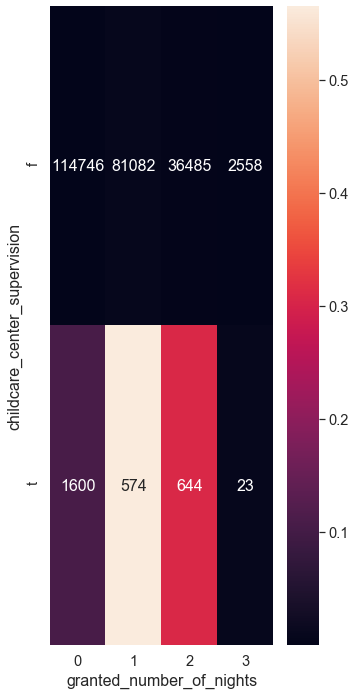

In [608]:
plot_cont(X="childcare_center_supervision",
    Y="granted_number_of_nights",
    data=requests_train)

=> childcare_center_supervision and number_of_underage can be used as feature

### birth_year

mean or max or min ?

When have been done requests ?

In [678]:
requests_train["request_creation_date"].min()

'2019-01-01 00:42:43.371'

In [679]:
requests_train["request_creation_date"].max()

'2019-03-31 23:54:45.705'

In [680]:
requests_test["request_creation_date"].min()

'2019-01-01 01:56:03.424'

In [681]:
requests_test["request_creation_date"].max()

'2019-03-31 23:20:15.031'

=> in 2019

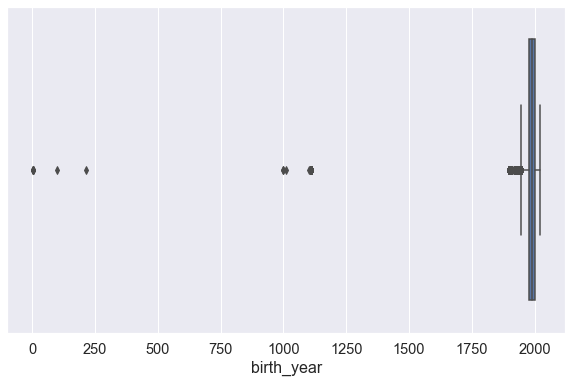

In [682]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot(x="birth_year", data=individuals_train, orient="h");

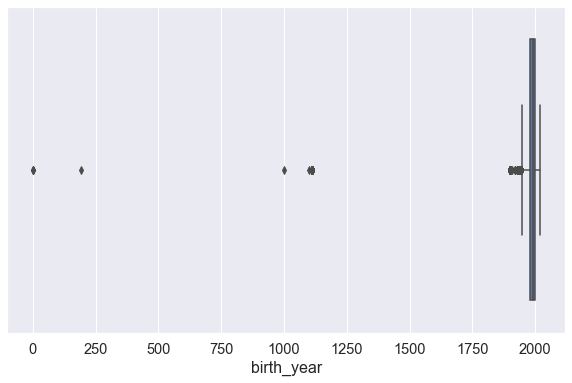

In [683]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot(x="birth_year", data=individuals_test, orient="h");

In [684]:
individuals_train[individuals_train["birth_year"] > 2019] \
    ["birth_year"].value_counts()

2021    1
Name: birth_year, dtype: int64

In [685]:
individuals_test[individuals_test["birth_year"] > 2019] \
    ["birth_year"].value_counts()

Series([], Name: birth_year, dtype: int64)

=> NOK : request are done in 2019. So max is 2019.

We correct by replacing with 2019

In [686]:
individuals_train.loc[individuals_train["birth_year"] > 2019, "birth_year"] = \
    2019
individuals_test.loc[individuals_test["birth_year"] > 2019, "birth_year"] = \
    2019

In [687]:
individuals_train[individuals_train["birth_year"] < 1901] \
    ["birth_year"].value_counts()

1900    2076
1111     191
1          6
1000       2
215        1
1100       1
1010       1
100        1
Name: birth_year, dtype: int64

In [688]:
individuals_test[individuals_test["birth_year"] < 1901] \
    ["birth_year"].value_counts()

 1900    556
 1111     48
 1         2
 1000      1
 190       1
 1098      1
-1         1
Name: birth_year, dtype: int64

=> NOK : we have to correct this data if we want to keep all samples

We choose to replace by mean value over all train samples

In [689]:
year_mean = np.round( \
individuals_train[individuals_train["birth_year"] >= 1901]["birth_year"].mean())
year_mean

1990.0

In [690]:
individuals_train.loc[individuals_train["birth_year"] < 1901, "birth_year"] = \
    year_mean
individuals_test.loc[individuals_test["birth_year"] < 1901, "birth_year"] = \
    year_mean

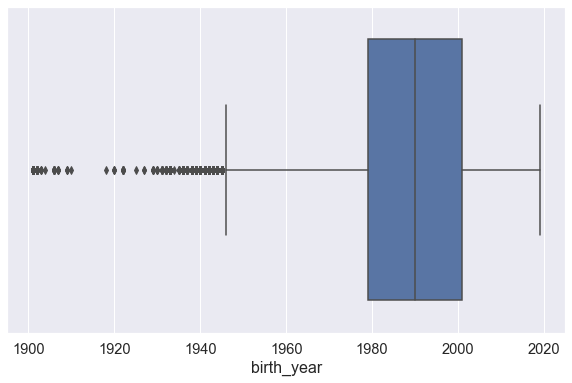

In [691]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot(x="birth_year", data=individuals_train, orient="h");

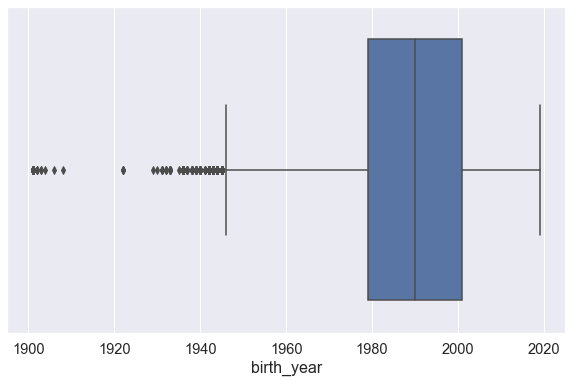

In [692]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot(x="birth_year", data=individuals_test, orient="h");

In [693]:
pt_req_year_train = pd.pivot_table(individuals_train, 
                              values='birth_year', 
               index=['request_id'], aggfunc=["min","max","mean"])
pt_req_year_train.columns = ["age_max", "age_min", "age_mean"]
pt_req_year_train = 2019 - pt_req_year_train
pt_req_year_train

,age_max,age_min,age_mean
request_id,,,
0000602749161524aedd04269957e5fc,23.0,23.0,23.0
0000c66f6bb24e930cba6a3872d3ab02,38.0,38.0,38.0
0000dbd253c096eab97cab0545915ab2,19.0,19.0,19.0
0001826bdd626262ec2bda3a1b908aac,39.0,39.0,39.0
0001925b4cd4d65110638ee3d5f2f454,26.0,26.0,26.0
...,...,...,...
fffd7c7c22a9147bc4af4b869eb97f19,33.0,33.0,33.0
fffeeac2155c826f0ccc2f912c1049f9,42.0,42.0,42.0
fffeff160a0bf8c160c9e63436273cec,31.0,31.0,31.0


In [694]:
pt_req_year_train.describe()

,age_max,age_min,age_mean
count,238191.000000,238191.000000,238191.000000
mean,36.609439,29.157021,32.691396
std,12.548452,17.214400,13.612519
min,0.000000,0.000000,0.000000
25%,27.000000,19.000000,22.000000
50%,35.000000,29.000000,29.750000
75%,44.000000,41.000000,41.000000
max,118.000000,118.000000,118.000000


In [695]:
pt_req_year_test = pd.pivot_table(individuals_test, 
                              values='birth_year', 
               index=['request_id'], aggfunc=["min","max","mean"])
pt_req_year_test.columns = ["age_max", "age_min", "age_mean"]
pt_req_year_test = 2019 - pt_req_year_test
pt_req_year_test

,age_max,age_min,age_mean
request_id,,,
00025115a1823cf8dc4e405fac55aa08,48.0,4.0,24.666667
000329aa7e358635d26ff2d82a3f51d9,27.0,3.0,15.750000
00035ca76ed77fd146fbd433fdccd8a5,20.0,20.0,20.000000
0004db4b2bf9997bbd68d59c5c4d65a5,33.0,1.0,17.000000
00072464a3949529d9093a7622806527,25.0,25.0,25.000000
...,...,...,...
fffd6850c8daf68dcdf737647952f40d,45.0,45.0,45.000000
fffe858cbae1fcf6093a9676d81119d9,27.0,0.0,13.500000
fffec8a1dff845182d68e56ed8329a37,58.0,58.0,58.000000


In [696]:
pt_req_year_test.describe()

,age_max,age_min,age_mean
count,59548.000000,59548.000000,59548.000000
mean,36.566333,29.173826,32.670515
std,12.479526,17.114133,13.535322
min,0.000000,0.000000,0.000000
25%,27.000000,19.000000,22.000000
50%,35.000000,29.000000,30.000000
75%,44.000000,40.000000,41.000000
max,118.000000,118.000000,118.000000


In [697]:
df_test = requests_train.copy()
df_test = df_test.join(pt_req_year_train, on="request_id")
df_test.head().T

,0,1,2,3,4
request_id,130667d2964de43c511d0ead7ac66b33,b1cd62fcf24eebb0f685d5eaf55317a8,eae4762c0c04f515269ab781acd72767,61d89004239ffae3a210f94f74e052f9,3ab1f3e0f31b81d24ac5dc06a7d02184
animal_presence,f,f,f,f,f
answer_creation_date,2019-02-11 22:30:00,2019-02-12 09:00:00,2019-02-22 13:00:00,2019-02-05 13:00:00,2019-02-09 09:00:00
child_situation,-1,-1,-1,-1,-1
child_to_come,unknown,unknown,unknown,unknown,f
district,85,85,85,85,85
granted_number_of_nights,1,1,0,0,0
group_composition_id,10,10,10,10,10
group_composition_label,man alone,man alone,man alone,man alone,man alone
group_creation_date,2018-05-03 12:10:40.416,2019-03-07 12:11:08.545,2019-04-02 08:30:02.818,2018-08-01 13:33:57.065,2017-12-15 18:22:15.632


In [698]:
requests_train = df_test.copy()

In [699]:
df_test = requests_test.copy()
df_test = df_test.join(pt_req_year_test, on="request_id")
df_test.head().T

,0,1,2,3,4
request_id,6a94e460b649033f78a6b136815364af,2f6cd16f85ef7afaffab1441ef0a20ed,108ad82e01191a37e541c875950bb7b6,b688349b7ee3a332875734926fd2a900,a40730ea8b82cde83a8959c2ac32d7a6
animal_presence,f,f,f,f,f
answer_creation_date,2019-02-27 08:21:23.301,2019-02-19 07:30:39.447,2019-02-21 12:15:08.279,2019-02-24 15:13:08.52,2019-02-01 14:24:04.063
child_situation,-1,-1,-1,-1,-1
child_to_come,NaN,f,NaN,NaN,NaN
district,60,60,60,60,60
granted_number_of_nights,0,0,0,0,0
group_composition_id,40,10,30,40,10
group_composition_label,single mother with child(ren),man alone,couple without whildren,single mother with child(ren),man alone
group_creation_date,2019-01-23 11:26:20.206,2018-07-30 17:39:19.208,2019-01-15 15:54:53.352,2019-01-20 14:29:03.521,2018-07-27 08:32:13.376


In [700]:
requests_test = df_test.copy()

=> OK, we can use "age_x" as feature.

### disabled_worker_certification

### gender 	

### marital_status_label

## Save 

In [701]:
requests_train.to_csv(path_or_buf=PATH_REQ_TRAIN_CLEAN, index=False)

In [702]:
requests_test.to_csv(path_or_buf=PATH_REQ_TEST_CLEAN, index=False)